In [1]:
import interpret.glassbox
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl

In [2]:
# Let's suppress warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
class_names = ['Normal', 'Pneumonia', 'Tuberculosis']

In [4]:
handcrafted_features = pd.read_csv('handcrafted_features.csv', sep=',')
handcrafted_labels = np.load('handcrafted_labels.npy')

In [5]:
handcrafted_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10792 entries, 0 to 10791
Data columns (total 68 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   mean intensity             10792 non-null  float64
 1   std intensity              10792 non-null  float64
 2   median intesity            10792 non-null  float64
 3   q25 intensity              10792 non-null  float64
 4   q50 intensity              10792 non-null  float64
 5   q75 intensity              10792 non-null  float64
 6   lbp_hist_0                 10792 non-null  float64
 7   lbp_hist_1                 10792 non-null  float64
 8   lbp_hist_2                 10792 non-null  float64
 9   lbp_hist_3                 10792 non-null  float64
 10  lbp_hist_4                 10792 non-null  float64
 11  lbp_hist_5                 10792 non-null  float64
 12  lbp_hist_6                 10792 non-null  float64
 13  lbp_hist_7                 10792 non-null  flo

In [6]:
handcrafted_features.describe()

mean intensity  std intensity  median intesity  q25 intensity  \
count    10792.000000   10792.000000     10792.000000   10792.000000   
mean       127.095352      60.081293       125.727993      80.939075   
std          6.485709       3.354943         7.655192      13.266976   
min         86.850363      29.628881        41.000000      40.000000   
25%        123.013019      57.970259       121.000000      74.000000   
50%        128.553494      60.339076       127.000000      84.000000   
75%        131.186910      62.281452       131.000000      91.000000   
max        183.128494      78.650343       198.000000     118.000000   

       q50 intensity  q75 intensity    lbp_hist_0    lbp_hist_1    lbp_hist_2  \
count   10792.000000   10792.000000  10792.000000  10792.000000  10792.000000   
mean      125.727993     170.494186      0.025418      0.031426      0.031960   
std         7.655192       7.014682      0.009166      0.011203      0.007522   
min        41.000000     131.000000      0.001041      0.002868      0.004669   
25%       121.000000     166.000000      0.021811      0.025886      0.030687   
50%       127.000000     170.000000      0.026297      0.032984      0.033644   
75%       131.000000     174.000000      0.030815      0.039020      0.036212   
max       198.000000     255.000000      0.095279      0.080818      0.062711   

         lbp_hist_3  ...  wavelet_cV_mean  wavelet_cV_variance  \
count  10792.000000  ...     10792.000000         10792.000000   
mean       0.034306  ...        -0.000556            44.228998   
std        0.006500  ...         0.114997            25.092529   
min        0.006368  ...        -0.550775             0.400975   
25%        0.032048  ...        -0.032064            22.865179   
50%        0.035356  ...        -0.000386            47.663528   
75%        0.038247  ...         0.027453            59.362032   
max        0.058047  ...         0.567488           436.943247   

       wavelet_cV_skewness  wavelet_cV_kurtosis  wavelet_cD_energy  \
count         10792.000000         10792.000000       1.079200e+04   
mean              0.030944             9.040538       9.740720e+04   
std               0.405309             9.988028       1.363456e+05   
min              -4.470905            -0.159703       7.728500e+03   
25%              -0.102386             4.848480       4.380650e+04   
50%               0.028066             6.416410       5.731438e+04   
75%               0.156089            10.211909       1.199354e+05   
max               5.394581           240.143987       7.075612e+06   

       wavelet_cD_entropy  wavelet_cD_mean  wavelet_cD_variance  \
count             10792.0     10792.000000         10792.000000   
mean                  inf        -0.000038             0.921542   
std                   NaN         0.001161             0.757258   
min                   inf        -0.005487             0.037053   
25%                   NaN        -0.000600             0.376942   
50%                   NaN        -0.000015             0.824164   
75%                   NaN         0.000525             1.350072   
max                   inf         0.005150            29.440656   

       wavelet_cD_skewness  wavelet_cD_kurtosis  
count         10792.000000         10792.000000  
mean              0.001056             6.877258  
std               0.076372             4.696594  
min              -0.565911             0.029896  
25%              -0.030638             4.413906  
50%               0.000919             6.008216  
75%               0.032750             8.057654  
max               0.677796            72.435617  

[8 rows x 68 columns]

<BarContainer object of 3 artists>

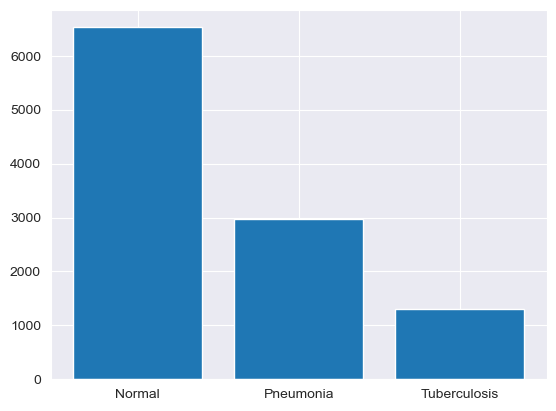

In [7]:
from collections import Counter

# Class distribution
labels_numerical = np.argmax(handcrafted_labels, axis=1)

counter = Counter(labels_numerical)
counts = [counter[0], counter[1], counter[2]]

plt.bar(x=class_names, height=counts)

In [8]:
counter.items()

dict_items([(0, 6528), (2, 1296), (1, 2968)])

<Axes: >

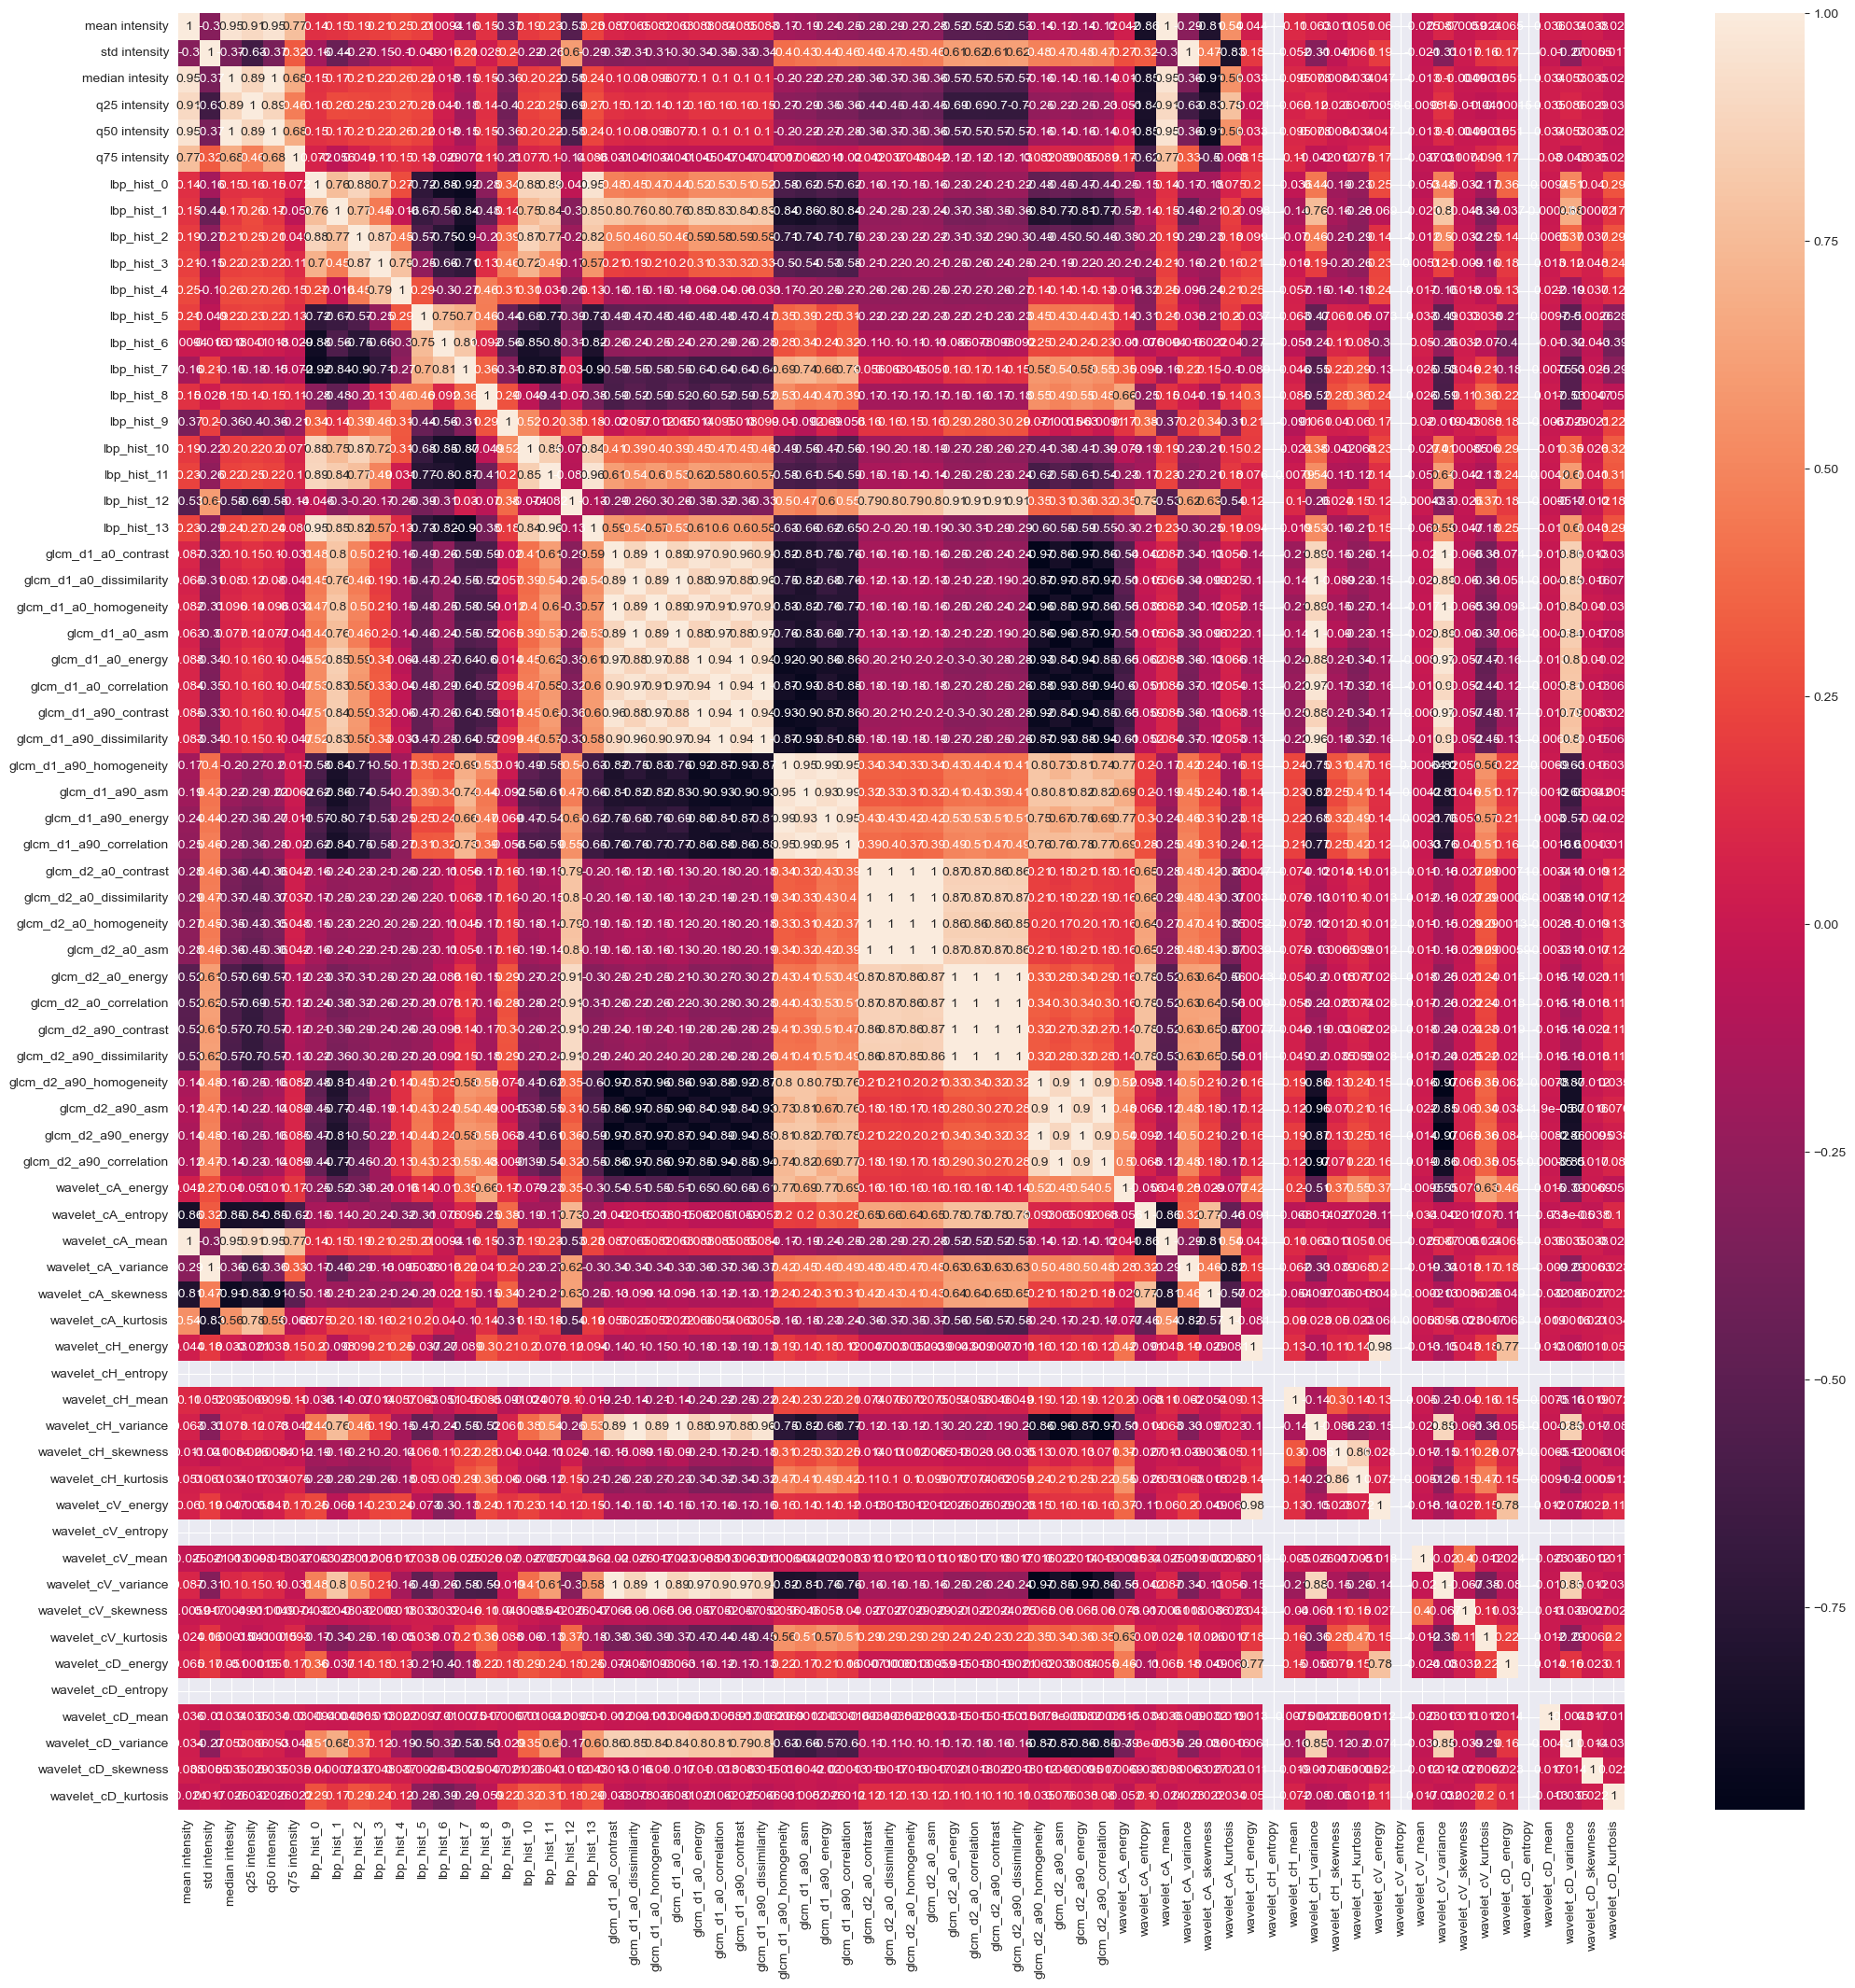

In [9]:
# Draw the heatmap of correlation
fig, ax = plt.subplots(figsize=(25,25))
sns.heatmap(handcrafted_features.corr(), ax=ax, annot=True)

# How to proceed?
There are too many features to handle at a time. Let's consider subsets based on the technique used to extract them:

1. Base statistics
2. Local Binary Pattern Histogram
3. Gray-Level Co-Occurrence Matrix (GLCM)
4. Wavelet Texture Features

## Base Statistics

In [10]:
feature_names = ['mean intensity', 'std intensity', 'median intesity', 'q25 intensity', 'q50 intensity', 'q75 intensity']
base_statistics_features = handcrafted_features[feature_names]

labels_numerical = np.argmax(handcrafted_labels, axis=1)

base_statistics_features.describe()

mean intensity  std intensity  median intesity  q25 intensity  \
count    10792.000000   10792.000000     10792.000000   10792.000000   
mean       127.095352      60.081293       125.727993      80.939075   
std          6.485709       3.354943         7.655192      13.266976   
min         86.850363      29.628881        41.000000      40.000000   
25%        123.013019      57.970259       121.000000      74.000000   
50%        128.553494      60.339076       127.000000      84.000000   
75%        131.186910      62.281452       131.000000      91.000000   
max        183.128494      78.650343       198.000000     118.000000   

       q50 intensity  q75 intensity  
count   10792.000000   10792.000000  
mean      125.727993     170.494186  
std         7.655192       7.014682  
min        41.000000     131.000000  
25%       121.000000     166.000000  
50%       127.000000     170.000000  
75%       131.000000     174.000000  
max       198.000000     255.000000

<Axes: >

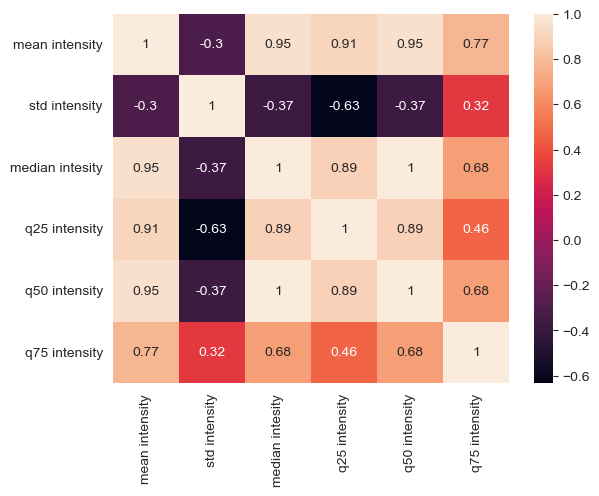

In [11]:
sns.heatmap(base_statistics_features.corr(), annot=True)

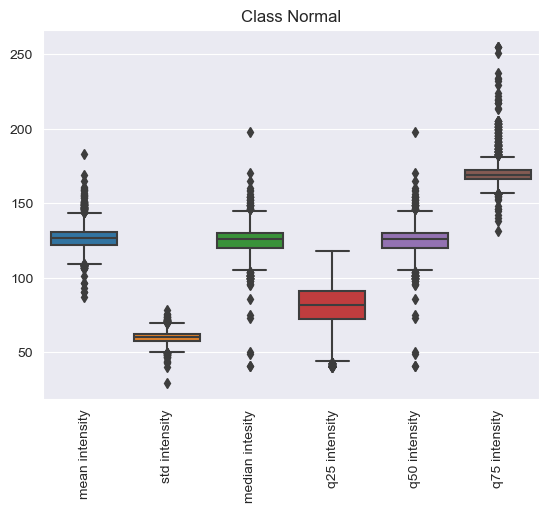

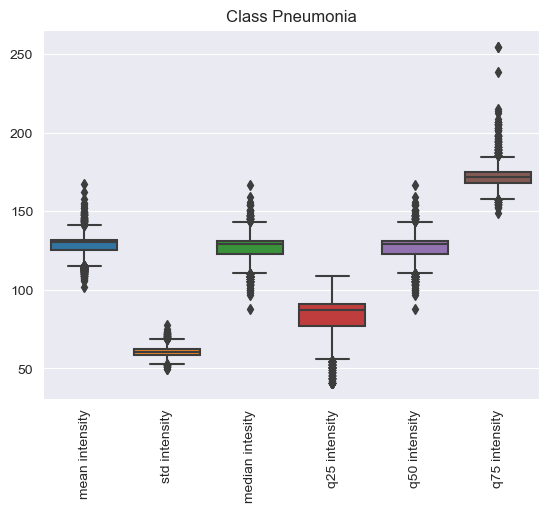

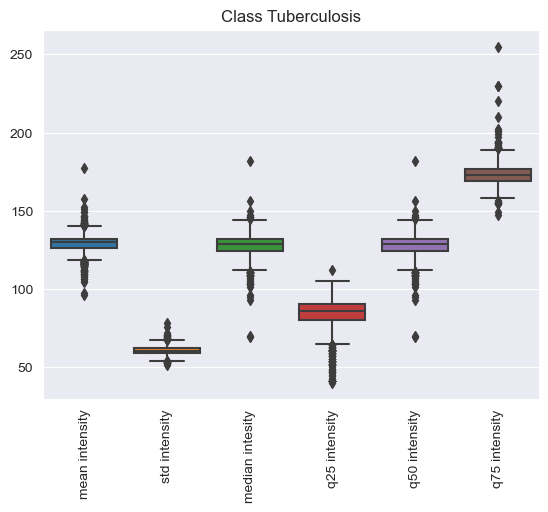

In [12]:
# For each class, let's see the distribution of the features through a boxplot
for i in range(0, 3):
    bp = sns.boxplot(data=base_statistics_features[labels_numerical == i])
    bp.set_title('Class {}'.format(class_names[i]))
    bp.set_xticklabels(bp.get_xticklabels(), rotation=90)
    plt.show()

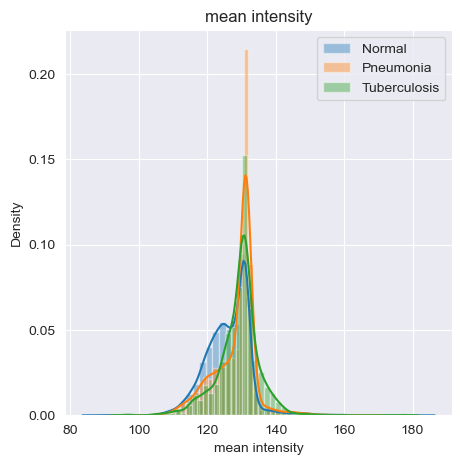

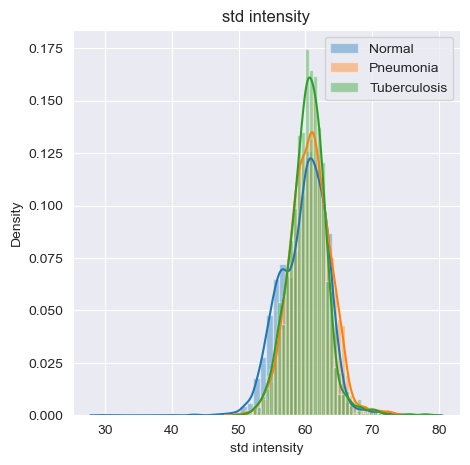

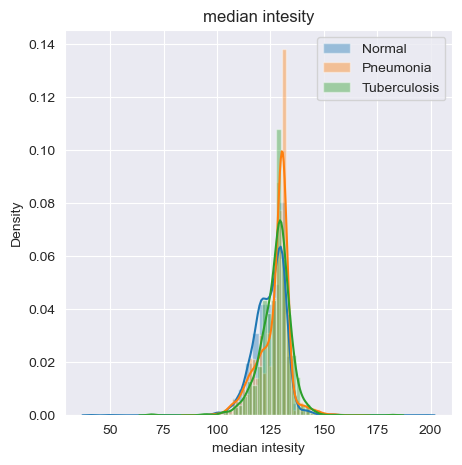

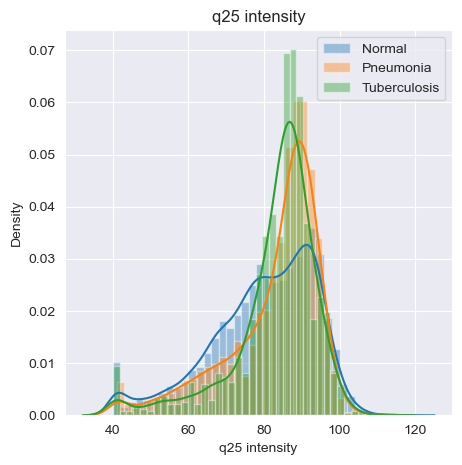

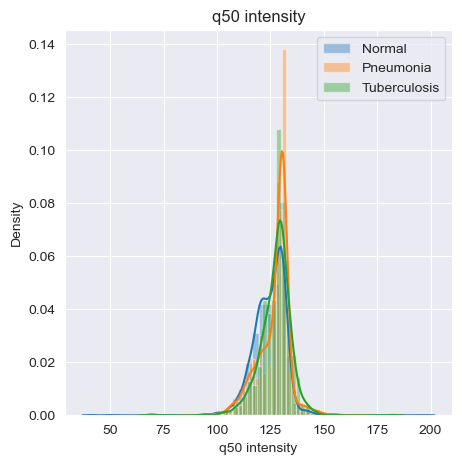

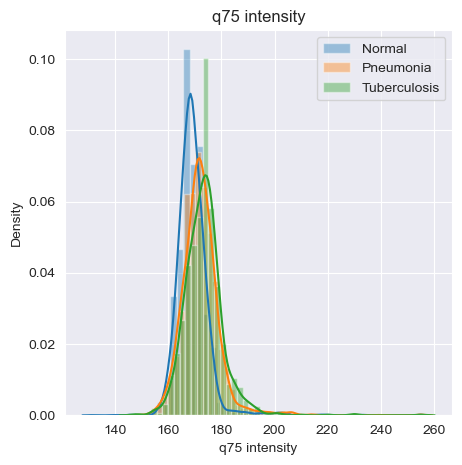

In [13]:
# For each feature, let's plot an histogram for each class and have them overlap
for i in range(0, 6):
    fig, ax = plt.subplots(figsize=(5,5))
    for j in range(0, 3):
        sns.distplot(base_statistics_features[labels_numerical == j][feature_names[i]], ax=ax, label=class_names[j])
    ax.legend()
    ax.set_title(feature_names[i])
    plt.show()

It seems that there is not much difference between the classes, so it's likely the model will perform poorly, and mostly capture noise but let's try anyway to get a baseline.

In [14]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Split the data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(base_statistics_features.to_numpy(), labels_numerical, test_size=0.3)

# Undersample class 0
normal_train_samples = np.where(y_train == 0)[0]
chosen = np.random.choice(normal_train_samples, 3000)
excluded = np.setdiff1d(normal_train_samples, chosen)
X_test = np.concatenate([X_test, X_train[excluded, :]], axis=0)
y_test = np.concatenate([y_test, y_train[excluded]], axis=0)

X_train = X_train[np.setdiff1d(np.arange(0, X_train.shape[0]), excluded), :]
y_train = y_train[np.setdiff1d(np.arange(0, y_train.shape[0]), excluded)]


# Let's apply robust scaling to the features
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the model
logreg = LogisticRegression(class_weight={0:0.9, 1:1.2, 2:3.0}).fit(X_train, y_train)

# Predict on test set
y_pred = logreg.predict(X_test)

# Evaluate the model
accuracy_score(y_test, y_pred)

0.4053715308863026

In [15]:
# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

      Normal       0.89      0.35      0.50      4302
   Pneumonia       0.26      0.58      0.36       895
Tuberculosis       0.12      0.59      0.20       388

    accuracy                           0.41      5585
   macro avg       0.43      0.51      0.36      5585
weighted avg       0.74      0.41      0.46      5585



<Axes: >

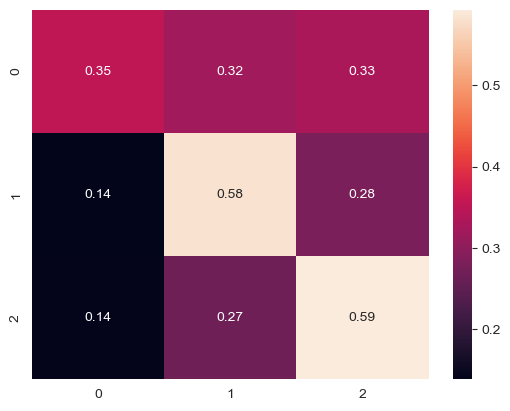

In [16]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm, annot=True)

Undersampling class 0 seems to have improved the results, but the model is still not able to distinguish between the classes.

As expected, base statistics seem to be correlated except for mean and std, so they could be a good choice to try a baseline model

In [17]:
base_statistics_features = base_statistics_features[['mean intensity', 'std intensity']]

In [18]:
# Split the data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(base_statistics_features, labels_numerical, test_size=0.3)


In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Train the model
rndfrst = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)

# Predict on test set
y_pred = rndfrst.predict(X_test)

# Evaluate the model
accuracy_score(y_test, y_pred)

0.6238418777022854

In [20]:
#Let's print accuracy, precision, recall and f1-score
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

      Normal       0.71      0.82      0.76      1982
   Pneumonia       0.44      0.39      0.41       847
Tuberculosis       0.34      0.15      0.20       409

    accuracy                           0.62      3238
   macro avg       0.49      0.45      0.46      3238
weighted avg       0.59      0.62      0.60      3238



<Axes: >

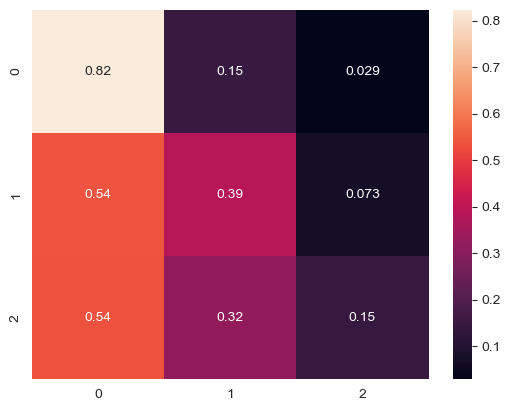

In [21]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm, annot=True)

Random Forest seems to perform better than Logistic Regression, but still not good enough. Let's try a different feature set.

## Local Binary Pattern Histogram

In [22]:
lbp_feature_names = [i for i in handcrafted_features if 'lbp' in i]
lbp_features = handcrafted_features[lbp_feature_names]

lbp_features.describe()

lbp_hist_0    lbp_hist_1    lbp_hist_2    lbp_hist_3    lbp_hist_4  \
count  10792.000000  10792.000000  10792.000000  10792.000000  10792.000000   
mean       0.025418      0.031426      0.031960      0.034306      0.048791   
std        0.009166      0.011203      0.007522      0.006500      0.006657   
min        0.001041      0.002868      0.004669      0.006368      0.011419   
25%        0.021811      0.025886      0.030687      0.032048      0.045368   
50%        0.026297      0.032984      0.033644      0.035356      0.048975   
75%        0.030815      0.039020      0.036212      0.038247      0.052487   
max        0.095279      0.080818      0.062711      0.058047      0.093936   

         lbp_hist_5    lbp_hist_6    lbp_hist_7    lbp_hist_8    lbp_hist_9  \
count  10792.000000  10792.000000  10792.000000  10792.000000  10792.000000   
mean       0.097057      0.217336      0.133994      0.056798      0.045420   
std        0.014218      0.060114      0.029455      0.006987      0.006010   
min        0.010406      0.010275      0.012077      0.011356      0.017325   
25%        0.088217      0.172898      0.116641      0.052668      0.042225   
50%        0.094592      0.210341      0.127806      0.055936      0.045669   
75%        0.102987      0.243673      0.141650      0.059723      0.049106   
max        0.156592      0.414227      0.257025      0.091984      0.075331   

        lbp_hist_10   lbp_hist_11   lbp_hist_12   lbp_hist_13  
count  10792.000000  10792.000000  10792.000000  10792.000000  
mean       0.034479      0.026949      0.060836      0.155229  
std        0.006527      0.007547      0.037341      0.051382  
min        0.012272      0.006896      0.013495      0.030613  
25%        0.032622      0.023136      0.035561      0.127969  
50%        0.035687      0.027591      0.050067      0.159662  
75%        0.038469      0.031330      0.075219      0.186848  
max        0.065320      0.082012      0.506677      0.529437

<Axes: >

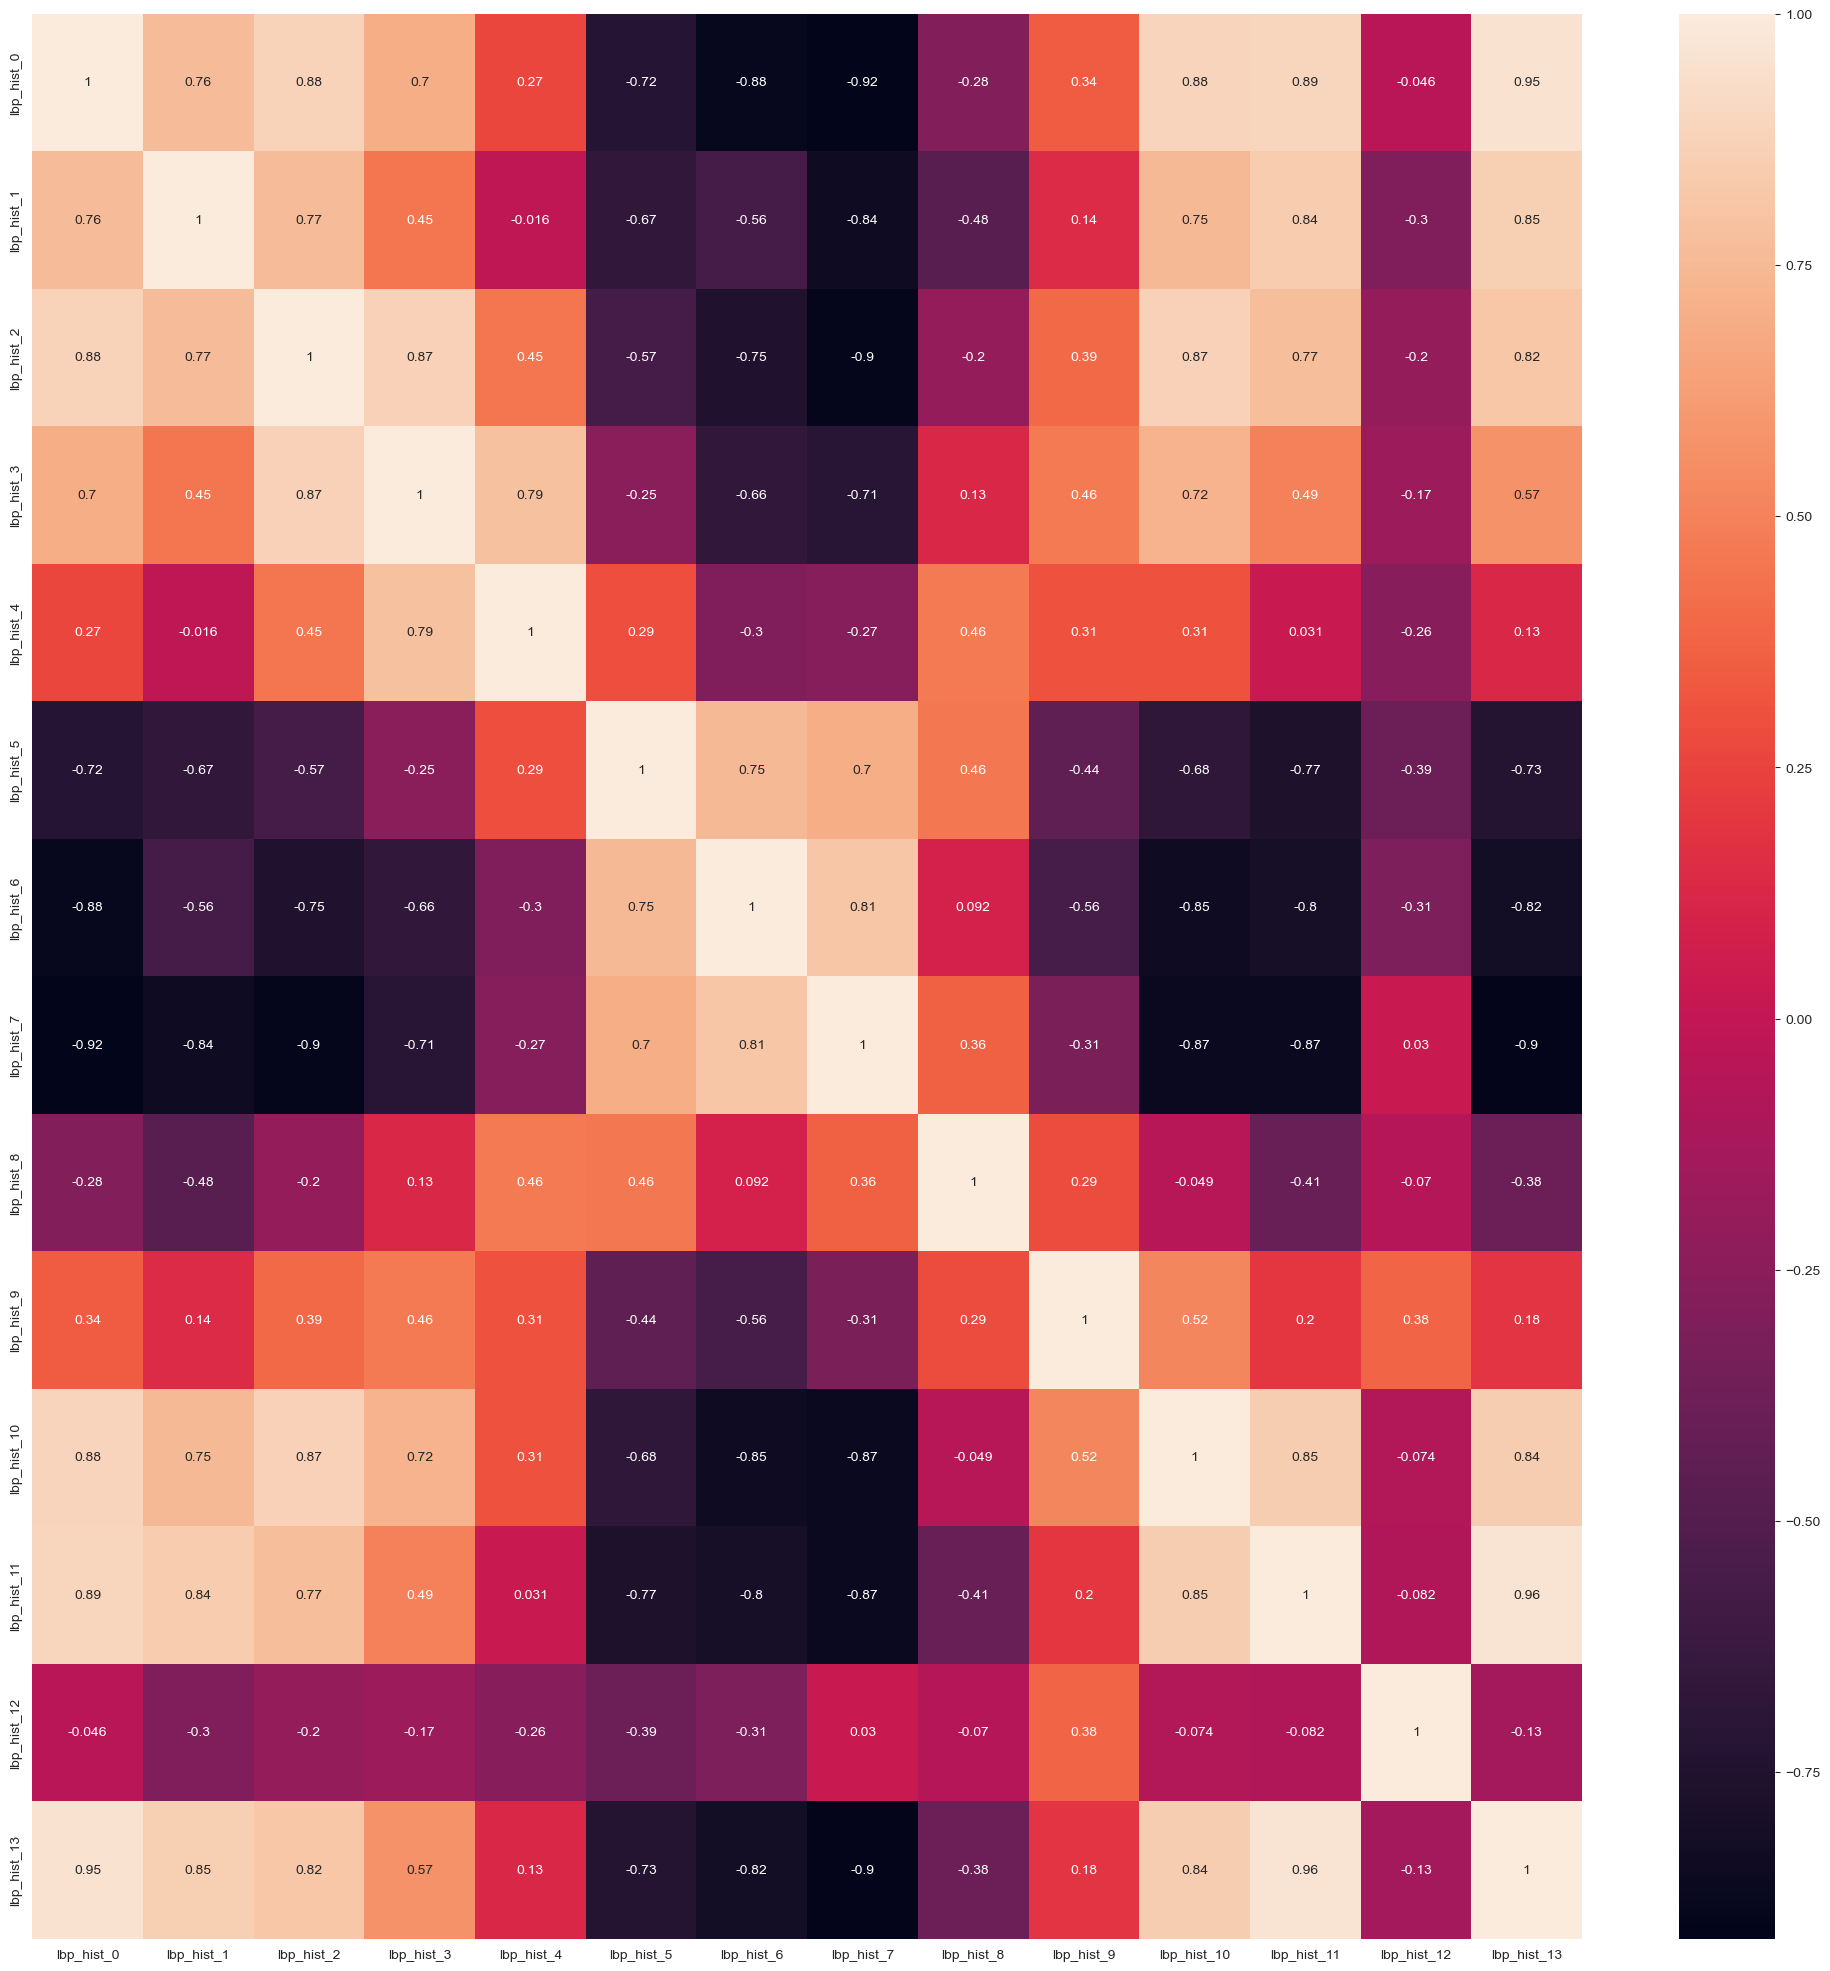

In [23]:
fig, ax = plt.subplots(figsize=(25,25))
sns.heatmap(lbp_features.corr(), annot=True, ax=ax)

In [24]:
# Let's try a Principal Component Analysis to see if we can reduce the dimensionality
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(lbp_features)
pca.explained_variance_ratio_

array([0.74177709, 0.19442781, 0.03580211])

In [25]:
pca_features = pca.transform(lbp_features)

X_train, X_test, y_train, y_test = train_test_split(pca_features, labels_numerical, test_size=0.3)

# Train the model
logisticRegr = LogisticRegression(class_weight={0:0.9, 1:1.1, 2:2.0}).fit(X_train, y_train)

# Predict on test set
y_pred = logisticRegr.predict(X_test)

# Evaluate the model
accuracy_score(y_test, y_pred)

0.5945027794935145

In [26]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

      Normal       0.61      0.98      0.75      1959
   Pneumonia       0.07      0.01      0.01       919
Tuberculosis       0.00      0.00      0.00       360

    accuracy                           0.59      3238
   macro avg       0.23      0.33      0.25      3238
weighted avg       0.39      0.59      0.46      3238



<Axes: >

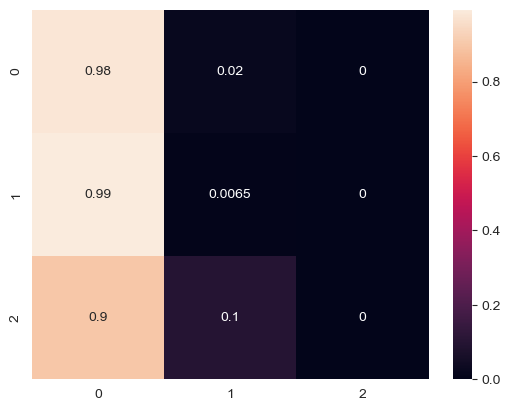

In [27]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm, annot=True)

No, PCA doesn't seem to help. Let's try a different model.

In [28]:
# Feature selection with SelectKBest
from sklearn.feature_selection import SelectKBest, chi2

X_train, X_mixed, y_train, y_mixed = train_test_split(lbp_features, labels_numerical, test_size=0.2)
X_test, X_val, y_test, y_val = train_test_split(X_mixed, y_mixed, test_size=0.1 / 0.8)

feat_selection = SelectKBest(chi2, k=3)
feat_selection.fit(X_val, y_val)

print(f'Feature scores: {feat_selection.scores_}')
print(f'Feature p-values: {feat_selection.pvalues_}')
print((f'Selected features: {lbp_features.columns[feat_selection.pvalues_ < 0.98]}'))

Feature scores: [2.04519818e-02 2.53064781e-02 1.76683115e-05 1.26559759e-03
 2.69170124e-03 3.17708642e-04 1.90718233e-01 4.23888686e-03
 4.72427264e-03 7.66292376e-03 2.27355040e-05 8.19985079e-03
 7.28268697e-02 9.76231315e-02]
Feature p-values: [0.98982612 0.98742648 0.99999117 0.9993674  0.99865505 0.99984116
 0.90904642 0.9978828  0.99764065 0.99617587 0.99998863 0.99590847
 0.96424156 0.95236057]
Selected features: Index(['lbp_hist_6', 'lbp_hist_12', 'lbp_hist_13'], dtype='object')


P-values are all very high, but since we selected them, let's try to train a model with them.

In [29]:
# Random Forest
X_train = feat_selection.transform(X_train)
X_test = feat_selection.transform(X_test)

# Train the model
rndfrst = RandomForestClassifier(n_estimators=256).fit(X_train, y_train)

# Predict on test set
y_pred = rndfrst.predict(X_test)

# Evaluate the model
accuracy_score(y_test, y_pred)

0.7517204870301747

In [30]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

      Normal       0.80      0.84      0.82      1160
   Pneumonia       0.70      0.78      0.74       495
Tuberculosis       0.48      0.28      0.35       234

    accuracy                           0.75      1889
   macro avg       0.66      0.63      0.64      1889
weighted avg       0.74      0.75      0.74      1889



<Axes: >

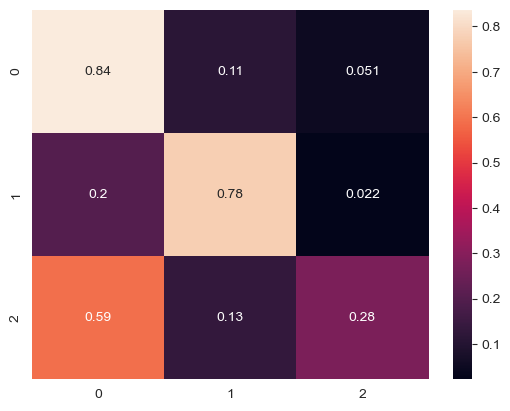

In [31]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm, annot=True)

## Gray-Level Co-Occurrence Matrix

In [32]:
glcm_feature_names = [i for i in handcrafted_features if 'glcm' in i]
glcm_features = handcrafted_features[glcm_feature_names]

glcm_features.describe()

glcm_d1_a0_contrast  glcm_d1_a0_dissimilarity  glcm_d1_a0_homogeneity  \
count         10792.000000              10792.000000            10792.000000   
mean             45.358702                 38.730971              168.955264   
std              25.895743                 23.620518               94.366006   
min               0.441969                  0.508153                1.476288   
25%              23.340735                 17.472559               87.383320   
50%              48.748249                 40.436767              183.664202   
75%              60.957702                 54.320725              227.157285   
max             466.771066                465.046249             1603.895350   

       glcm_d1_a0_asm  glcm_d1_a0_energy  glcm_d1_a0_correlation  \
count    10792.000000       10792.000000            10792.000000   
mean       142.830543           4.173068                3.592269   
std         85.064779           1.465660                1.308581   
min          1.623645           0.259955                0.294678   
25%         65.755412           3.084280                2.540963   
50%        150.686328           4.555282                3.877196   
75%        199.433587           5.132701                4.503006   
max       1602.103285          17.302201               17.242282   

       glcm_d1_a90_contrast  glcm_d1_a90_dissimilarity  \
count          10792.000000               10792.000000   
mean               8.140433                   6.976895   
std                2.818357                   2.494872   
min                0.514565                   0.579294   
25%                6.010557                   4.964015   
50%                8.911514                   7.561033   
75%               10.007613                   8.712519   
max               31.827641                  31.789077   

       glcm_d1_a90_homogeneity  glcm_d1_a90_asm  ...  glcm_d2_a0_homogeneity  \
count             10792.000000     10792.000000  ...            10792.000000   
mean                  0.320059         0.380291  ...                0.002549   
std                   0.107538         0.106790  ...                0.005800   
min                   0.056927         0.057431  ...                0.000035   
25%                   0.250288         0.307448  ...                0.000210   
50%                   0.287079         0.350532  ...                0.000748   
75%                   0.366193         0.432266  ...                0.003081   
max                   0.885331         0.879254  ...                0.173205   

       glcm_d2_a0_asm  glcm_d2_a0_energy  glcm_d2_a0_correlation  \
count    10792.000000       10792.000000            10792.000000   
mean         0.002705           0.042872                0.044758   
std          0.005835           0.031571                0.031348   
min          0.000035           0.007899                0.007905   
25%          0.000268           0.019476                0.021917   
50%          0.000821           0.031607                0.033435   
75%          0.003312           0.058650                0.060334   
max          0.172668           0.419518                0.419223   

       glcm_d2_a90_contrast  glcm_d2_a90_dissimilarity  \
count          10792.000000               10792.000000   
mean               0.038866                   0.040702   
std                0.032219                   0.032375   
min                0.005888                   0.005891   
25%                0.014496                   0.016379   
50%                0.027354                   0.028651   
75%                0.055507                   0.057551   
max                0.416179                   0.415533   

       glcm_d2_a90_homogeneity  glcm_d2_a90_asm  glcm_d2_a90_energy  \
count             10792.000000     10792.000000        10792.000000   
mean                  0.993513         0.994454            0.975810   
std                   0.003999         0.003667            0.014480   
min      

Also here we have a lot of features, let's see their correlation

<Axes: >

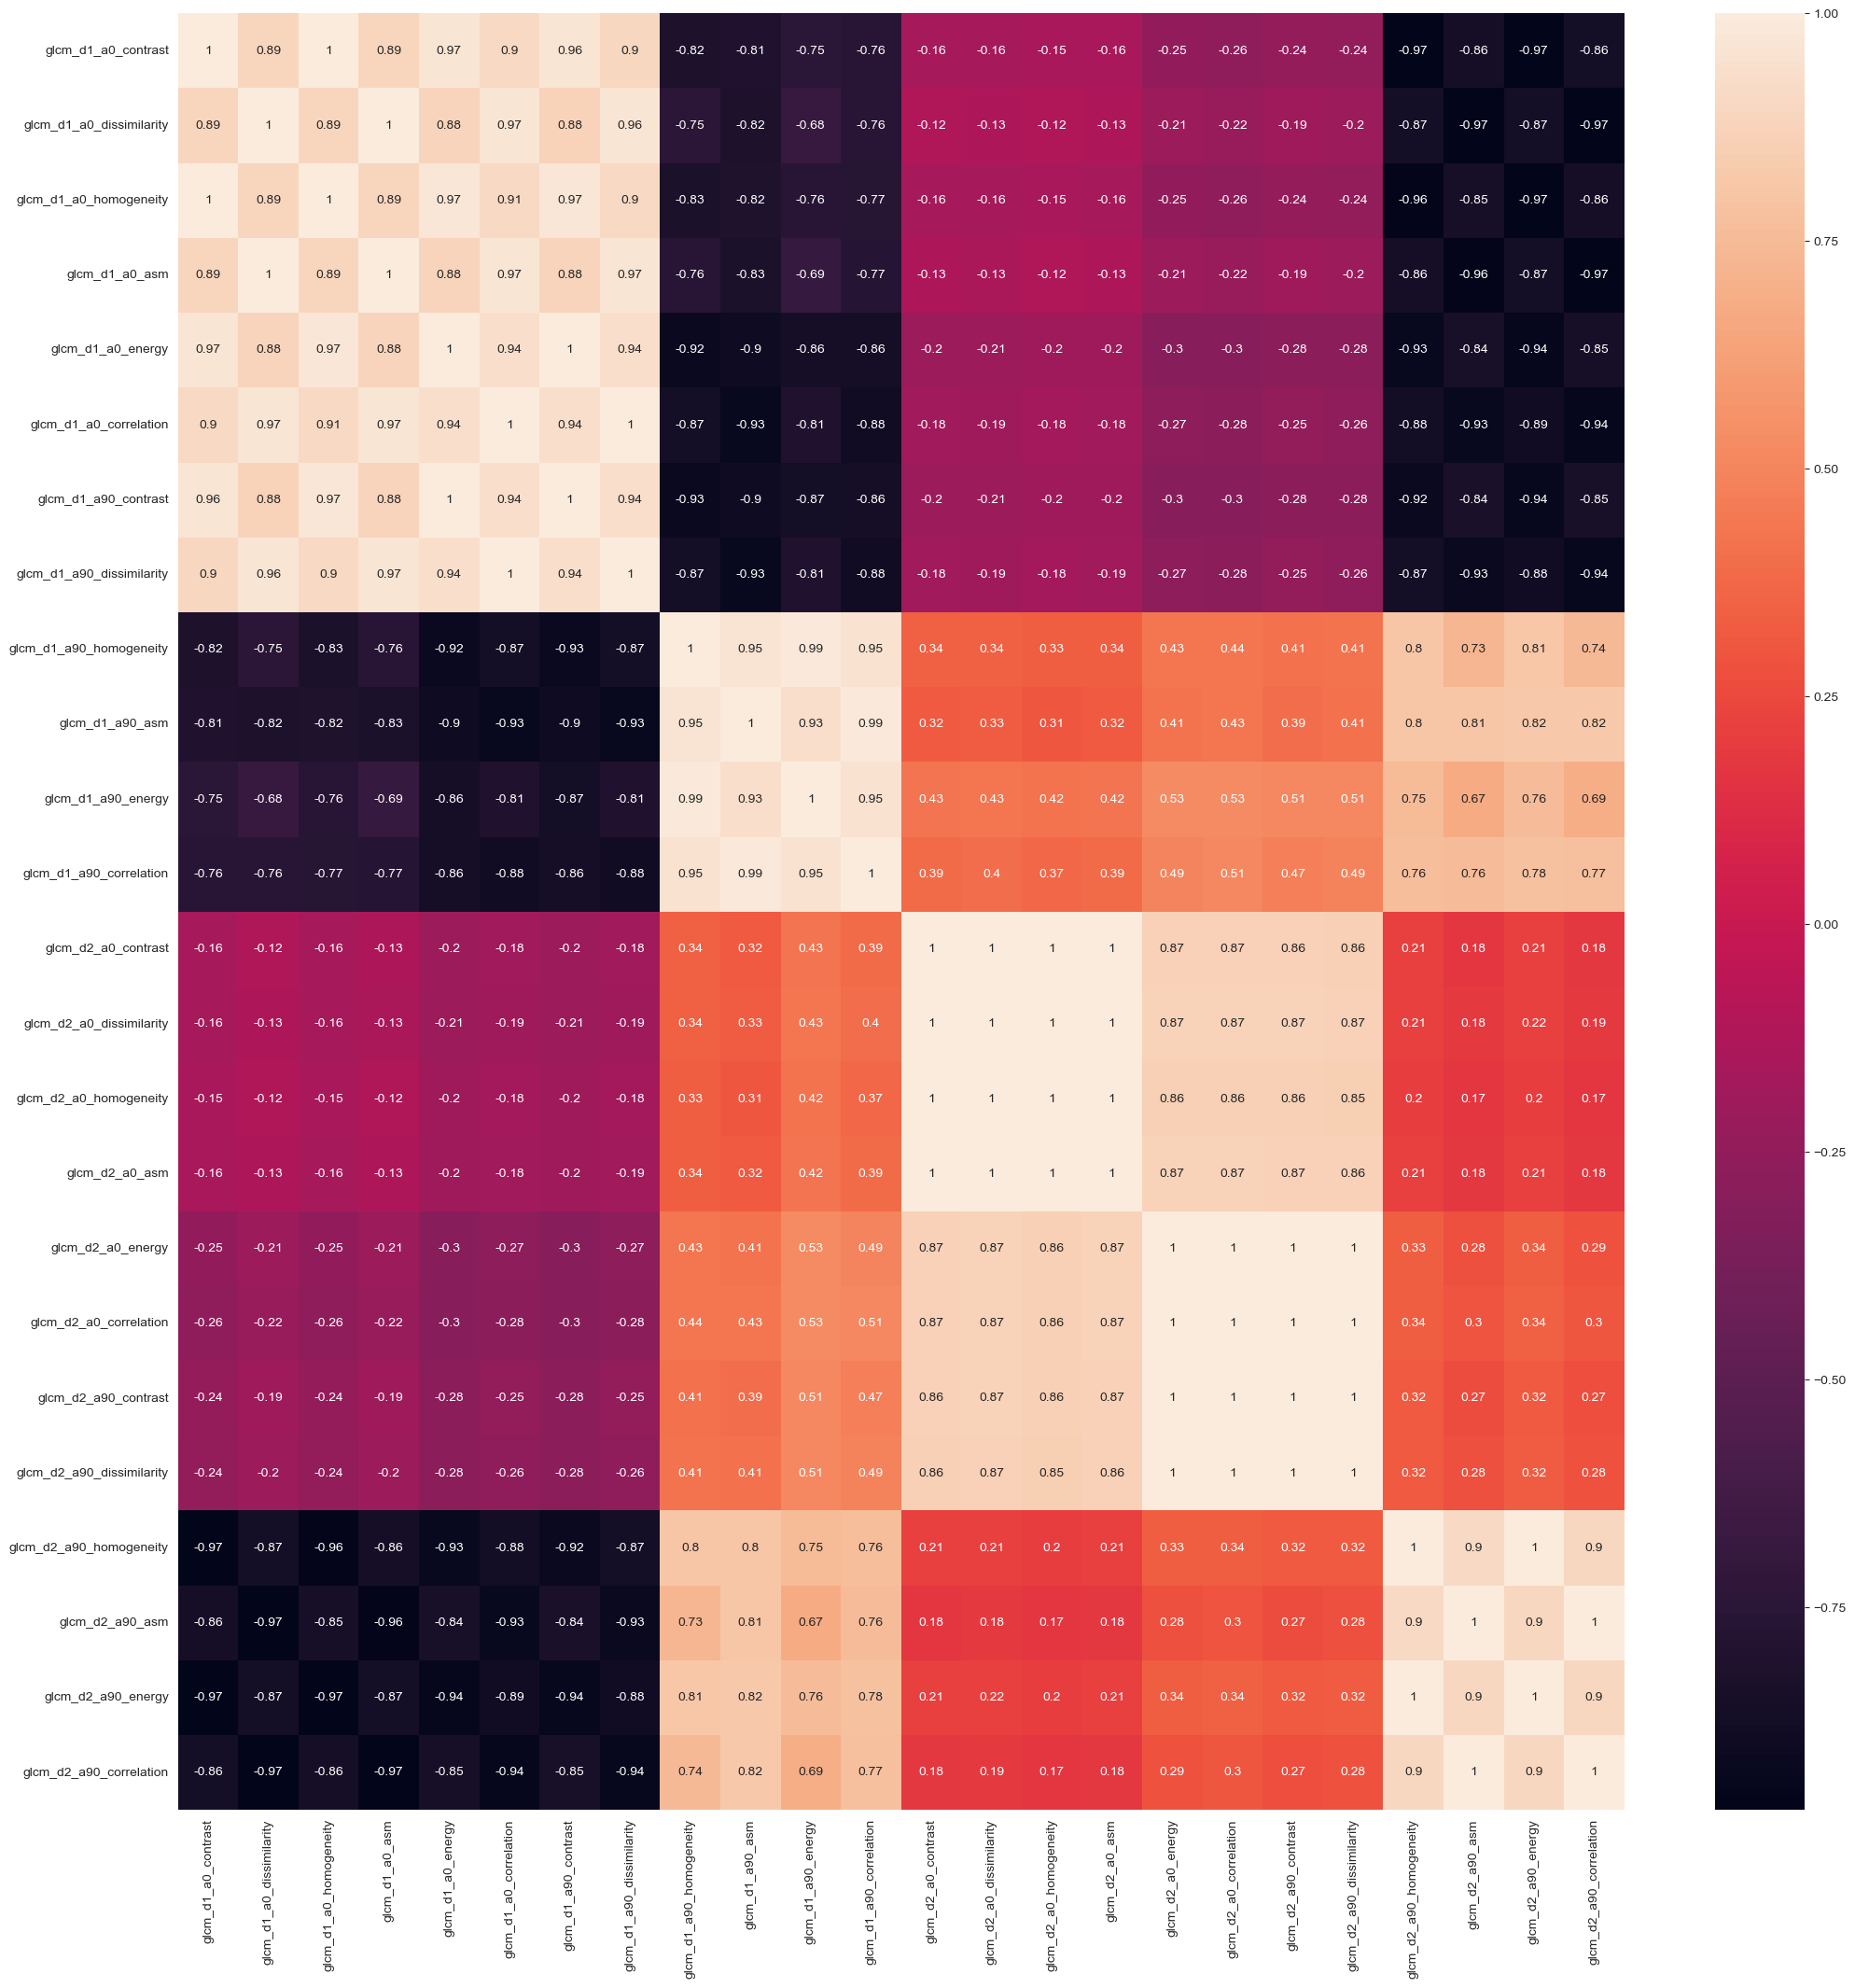

In [33]:
# Draw the heatmap of correlation
fig, ax = plt.subplots(figsize=(25,25))
sns.heatmap(glcm_features.corr(), ax=ax, annot=True)

They are blockwise highly correlated, let's try to select the best ones

In [34]:
# Feature selection with SelectKBest
from sklearn.feature_selection import SelectKBest, chi2

X_train, X_mixed, y_train, y_mixed = train_test_split(glcm_features, labels_numerical, test_size=0.2)
X_test, X_val, y_test, y_val = train_test_split(X_mixed, y_mixed, test_size=0.1 / 0.8)

feat_selection = SelectKBest(chi2, k=5)
feat_selection.fit(X_val, y_val)

print(f'Feature scores: {feat_selection.scores_}')
print(f'Feature p-values: {feat_selection.pvalues_}')

Feature scores: [4.23283348e+02 7.98561610e+02 1.64613488e+03 2.89058989e+03
 1.37810134e+01 2.45048975e+01 2.78576688e+01 4.70296338e+01
 3.49222041e-01 8.11859257e-01 1.63483944e-01 7.02660592e-01
 2.78358949e-02 2.64054009e-02 2.77545703e-02 2.83358683e-02
 1.32413719e-01 1.04279384e-01 1.62986066e-01 1.37320138e-01
 3.79816718e-04 5.95463931e-04 5.65149283e-03 8.15534643e-03]
Feature p-values: [1.21671524e-092 3.93142133e-174 0.00000000e+000 0.00000000e+000
 1.01739818e-003 4.77341416e-006 8.92861457e-007 6.13260206e-011
 8.39783616e-001 6.66357058e-001 9.21509703e-001 7.03751269e-001
 9.86178459e-001 9.86884073e-001 9.86218560e-001 9.85931959e-001
 9.35937237e-001 9.49196263e-001 9.21739132e-001 9.33644000e-001
 9.99810110e-001 9.99702312e-001 9.97178242e-001 9.95930629e-001]


This time we have some low p-values, let's try to train a model with the best 5 features.

In [35]:
X_train = feat_selection.transform(X_train)
X_test = feat_selection.transform(X_test)

In [36]:
# Logistic Regression
logisticRegr = LogisticRegression(class_weight={0:0.9, 1:1.1, 2:2.0}).fit(X_train, y_train)

# Predict on test set
y_pred = logisticRegr.predict(X_test)

# Evaluate the model
accuracy_score(y_test, y_pred)

0.6993118051879301

In [37]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

      Normal       0.81      0.73      0.77      1132
   Pneumonia       0.61      0.88      0.72       536
Tuberculosis       0.24      0.10      0.14       221

    accuracy                           0.70      1889
   macro avg       0.55      0.57      0.54      1889
weighted avg       0.69      0.70      0.68      1889



<Axes: >

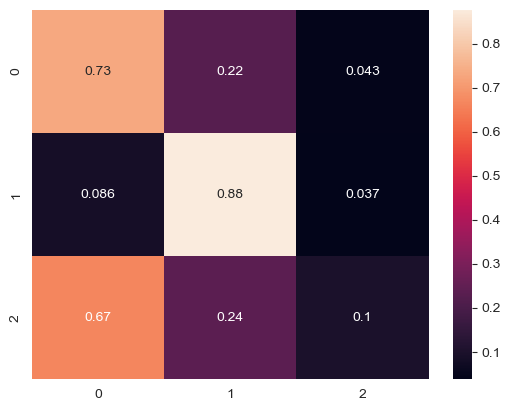

In [38]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm, annot=True)

In [39]:
# Random Forest
rndfrst = RandomForestClassifier(n_estimators=250).fit(X_train, y_train)

# Predict on test set
y_pred = rndfrst.predict(X_test)

# Evaluate the model
accuracy_score(y_test, y_pred)

0.7861302276336686

In [40]:
#Let's print accuracy, precision, recall and f1-score
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

      Normal       0.80      0.89      0.84      1132
   Pneumonia       0.81      0.77      0.79       536
Tuberculosis       0.52      0.27      0.35       221

    accuracy                           0.79      1889
   macro avg       0.71      0.64      0.66      1889
weighted avg       0.77      0.79      0.77      1889



<Axes: >

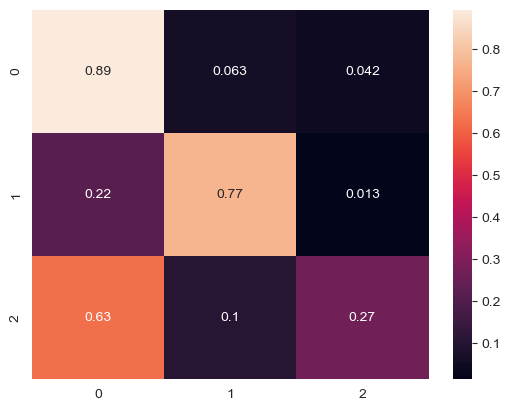

In [41]:
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm, annot=True)

# Wavelet Based Texture Features

In [42]:
wavelet_feature_names = [i for i in handcrafted_features if 'wavelet' in i]
wavelet_features = handcrafted_features[wavelet_feature_names]

wavelet_features.describe()

wavelet_cA_energy  wavelet_cA_entropy  wavelet_cA_mean  \
count       1.079200e+04        10792.000000     10792.000000   
mean        2.306048e+10            0.301026       254.187386   
std         4.589435e+10            0.105617        12.969688   
min         1.804164e+09            0.083611       173.700725   
25%         3.092321e+09            0.229750       246.026038   
50%         3.281386e+09            0.268810       257.105827   
75%         2.730955e+10            0.344148       262.363266   
max         5.999483e+11            1.699508       366.256987   

       wavelet_cA_variance  wavelet_cA_skewness  wavelet_cA_kurtosis  \
count         10792.000000         10792.000000         10792.000000   
mean          14401.903311             0.096413            -0.775470   
std            1623.615593             0.120997             0.172169   
min            3239.031237            -0.515765            -1.487428   
25%           13343.095055             0.012191            -0.904868   
50%           14479.907913             0.083970            -0.801681   
75%           15450.408956             0.175833            -0.664466   
max           24738.682847             1.007610             0.609154   

       wavelet_cH_energy  wavelet_cH_entropy  wavelet_cH_mean  \
count       1.079200e+04             10792.0     10792.000000   
mean        4.175901e+06                 inf        -0.076352   
std         7.825225e+06                 NaN         0.145719   
min         4.663935e+05                 inf        -0.557837   
25%         1.823998e+06                 NaN        -0.161000   
50%         2.298743e+06                 NaN        -0.052358   
75%         4.261008e+06                 NaN        -0.001934   
max         4.462693e+08                 inf         0.594087   

       wavelet_cH_variance  ...  wavelet_cV_mean  wavelet_cV_variance  \
count         10792.000000  ...     10792.000000         10792.000000   
mean             37.572948  ...        -0.000556            44.228998   
std              22.779694  ...         0.114997            25.092529   
min               0.451638  ...        -0.550775             0.400975   
25%              17.036933  ...        -0.032064            22.865179   
50%              39.340162  ...        -0.000386            47.663528   
75%              52.610490  ...         0.027453            59.362032   
max             435.442450  ...         0.567488           436.943247   

       wavelet_cV_skewness  wavelet_cV_kurtosis  wavelet_cD_energy  \
count         10792.000000         10792.000000       1.079200e+04   
mean              0.030944             9.040538       9.740720e+04   
std               0.405309             9.988028       1.363456e+05   
min              -4.470905            -0.159703       7.728500e+03   
25%              -0.102386             4.848480       4.380650e+04   
50%               0.028066             6.416410       5.731438e+04   
75%               0.156089            10.211909       1.199354e+05   
max               5.394581           240.143987       7.075612e+06   

       wavelet_cD_entropy  wavelet_cD_mean  wavelet_cD_variance  \
count             10792.0     10792.000000         10792.000000   
mean                  inf        -0.000038             0.921542   
std                   NaN         0.001161             0.757258   
min                   inf        -0.005487             0.037053   
25%                   NaN        -0.000600             0.376942   
50%                   NaN        -0.000015             0.824164   
75%                   NaN         0.000525             1.350072   
max                   inf         0.005150            29.440656   

       wavelet_cD_skewness  wavelet_cD_kurtosis  
count         10792.000000         10792.000000  
mean              0.001056             6.877258  
std               0.076372             4.696594  
min              -0.565911             0.029896  
25%              -0.030638             4.41

In [43]:
# Entropy features are either NaN or infinite, except for the one corresponding to the matrix cA, so let's drop them
wavelet_features = wavelet_features.drop(columns=[i for i in wavelet_features if 'entropy' in i and 'cA_entropy' not in i])

In [44]:
wavelet_features.describe()

wavelet_cA_energy  wavelet_cA_entropy  wavelet_cA_mean  \
count       1.079200e+04        10792.000000     10792.000000   
mean        2.306048e+10            0.301026       254.187386   
std         4.589435e+10            0.105617        12.969688   
min         1.804164e+09            0.083611       173.700725   
25%         3.092321e+09            0.229750       246.026038   
50%         3.281386e+09            0.268810       257.105827   
75%         2.730955e+10            0.344148       262.363266   
max         5.999483e+11            1.699508       366.256987   

       wavelet_cA_variance  wavelet_cA_skewness  wavelet_cA_kurtosis  \
count         10792.000000         10792.000000         10792.000000   
mean          14401.903311             0.096413            -0.775470   
std            1623.615593             0.120997             0.172169   
min            3239.031237            -0.515765            -1.487428   
25%           13343.095055             0.012191            -0.904868   
50%           14479.907913             0.083970            -0.801681   
75%           15450.408956             0.175833            -0.664466   
max           24738.682847             1.007610             0.609154   

       wavelet_cH_energy  wavelet_cH_mean  wavelet_cH_variance  \
count       1.079200e+04     10792.000000         10792.000000   
mean        4.175901e+06        -0.076352            37.572948   
std         7.825225e+06         0.145719            22.779694   
min         4.663935e+05        -0.557837             0.451638   
25%         1.823998e+06        -0.161000            17.036933   
50%         2.298743e+06        -0.052358            39.340162   
75%         4.261008e+06        -0.001934            52.610490   
max         4.462693e+08         0.594087           435.442450   

       wavelet_cH_skewness  ...  wavelet_cV_energy  wavelet_cV_mean  \
count         10792.000000  ...       1.079200e+04     10792.000000   
mean              0.384023  ...       4.859110e+06        -0.000556   
std               1.279924  ...       7.920382e+06         0.114997   
min              -5.617693  ...       6.376668e+05        -0.550775   
25%              -0.008366  ...       2.127229e+06        -0.032064   
50%               0.151279  ...       2.677708e+06        -0.000386   
75%               0.337912  ...       5.857930e+06         0.027453   
max              15.106138  ...       4.475466e+08         0.567488   

       wavelet_cV_variance  wavelet_cV_skewness  wavelet_cV_kurtosis  \
count         10792.000000         10792.000000         10792.000000   
mean             44.228998             0.030944             9.040538   
std              25.092529             0.405309             9.988028   
min               0.400975            -4.470905            -0.159703   
25%              22.865179            -0.102386             4.848480   
50%              47.663528             0.028066             6.416410   
75%              59.362032             0.156089            10.211909   
max             436.943247             5.394581           240.143987   

       wavelet_cD_energy  wavelet_cD_mean  wavelet_cD_variance  \
count       1.079200e+04     10792.000000         10792.000000   
mean        9.740720e+04        -0.000038             0.921542   
std         1.363456e+05         0.001161             0.757258   
min         7.728500e+03        -0.005487             0.037053   
25%         4.380650e+04        -0.000600             0.376942   
50%         5.731438e+04        -0.000015             0.824164   
75%         1.199354e+05         0.000525             1.350072   
max         7.075612e+06         0.005150            29.440656   

       wavelet_cD_skewness  wavelet_cD_kurtosis  
count         10792.000000         10792.000000  
mean              0.001056             6.877258  
std               0.076372             4.696594  
min              -0.565911             0.029896  
25%              -0.030638             4.41

<Axes: >

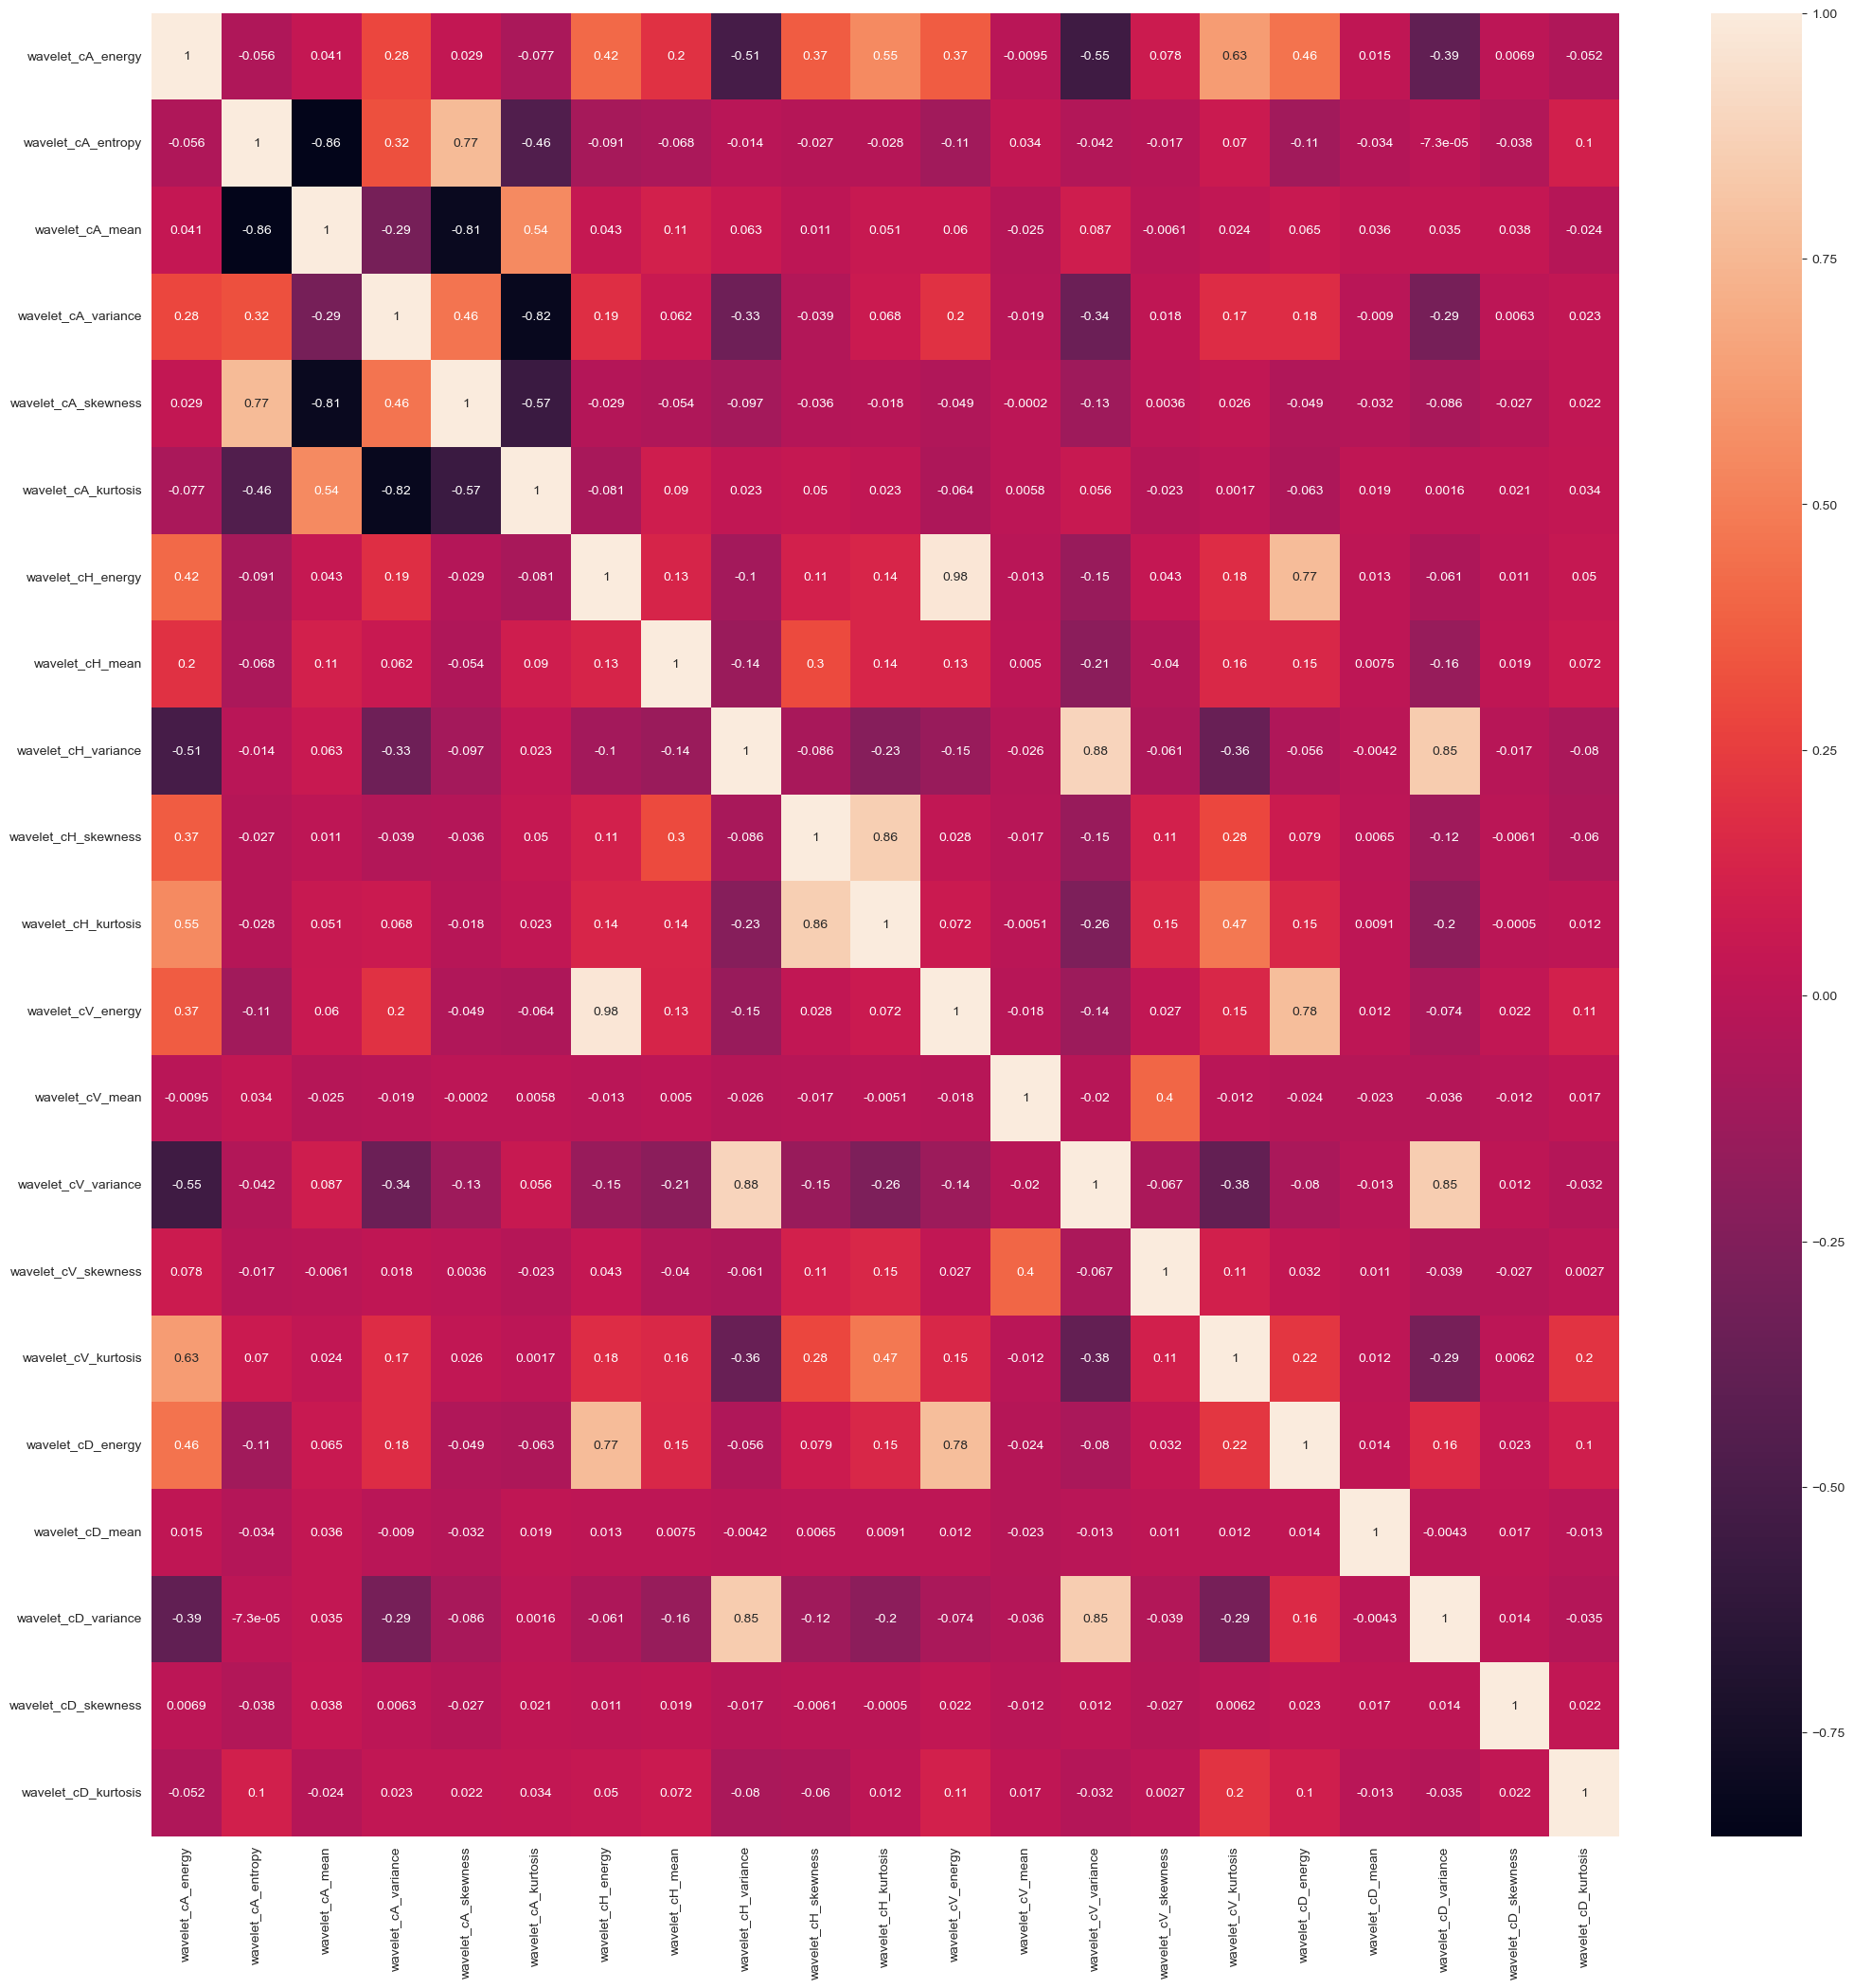

In [45]:
# Draw the heatmap of correlation
fig, ax = plt.subplots(figsize=(25,25))
sns.heatmap(wavelet_features.corr(), ax=ax, annot=True)

Let's assess the class separability of the features using t-SNE

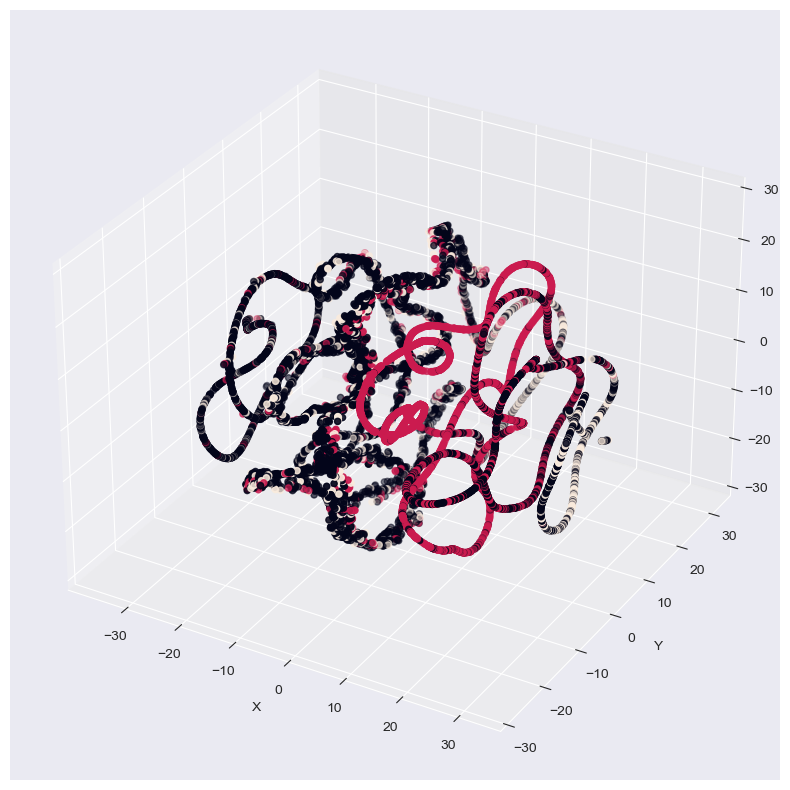

In [46]:
# t-SNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, perplexity=30)
tsne_features = tsne.fit_transform(wavelet_features)

#3d plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tsne_features[:,0], tsne_features[:,1], tsne_features[:,2], c=labels_numerical)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

The t-SNE forms snail-like shapes, which means that the features are not very separable.

In [47]:
# Let's try a PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
pca.fit(wavelet_features)
print(pca.explained_variance_ratio_)

[9.99999950e-01 4.91310595e-08 6.71657220e-10 3.13872480e-12
 1.12366573e-15 2.98958638e-19 2.89871025e-19 6.95336633e-20
 2.81591625e-20 2.27688894e-20]


Not much variance is explained by the first 10 components, let's try to select the best features. This time I pick mutual information as a metric because $\chi^2$ is not defined for negative values.

In [48]:
# Feature selection with SelectKBest
from sklearn.feature_selection import SelectKBest, mutual_info_classif

X_train, X_mixed, y_train, y_mixed = train_test_split(wavelet_features, labels_numerical, test_size=0.2)
X_test, X_val, y_test, y_val = train_test_split(X_mixed, y_mixed, test_size=0.1 / 0.8)

feat_selection = SelectKBest(mutual_info_classif, k=5)
feat_selection.fit(X_val, y_val)

print(f'Feature scores: {feat_selection.scores_}')

Feature scores: [0.43693347 0.1637403  0.02056948 0.08626059 0.00517422 0.
 0.18231789 0.17987214 0.2416317  0.03982556 0.11795863 0.28149574
 0.086243   0.24240753 0.00451676 0.04513148 0.24931187 0.02268039
 0.21409433 0.00943061 0.18981825]


In [49]:
X_train = feat_selection.transform(X_train)
X_test = feat_selection.transform(X_test)

In [50]:
# RobustScaler
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Logistic Regression
logisticRegr = LogisticRegression(class_weight={0:0.9, 1:1.1, 2:2.0}).fit(X_train, y_train)

# Predict on test set
y_pred = logisticRegr.predict(X_test)

# Evaluate the model
accuracy_score(y_test, y_pred)

0.7686606670195871

In [51]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

      Normal       0.78      0.88      0.82      1134
   Pneumonia       0.78      0.80      0.79       514
Tuberculosis       0.53      0.20      0.29       241

    accuracy                           0.77      1889
   macro avg       0.70      0.62      0.63      1889
weighted avg       0.75      0.77      0.75      1889



<Axes: >

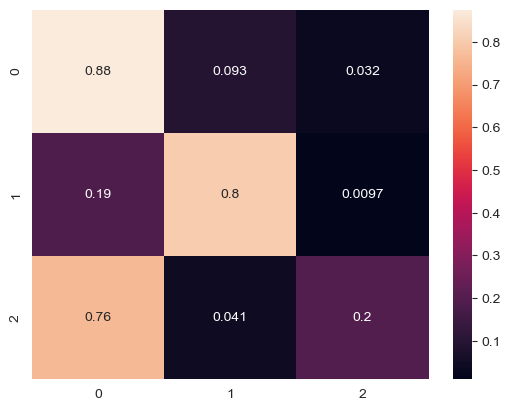

In [52]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm, annot=True)

In [53]:
# Train the model
rndfrst = RandomForestClassifier(n_estimators=250).fit(X_train, y_train)

# Predict on test set
y_pred = rndfrst.predict(X_test)

# Evaluate the model
accuracy_score(y_test, y_pred)

0.8517734250926416

In [54]:
#Let's print accuracy, precision, recall and f1-score
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

      Normal       0.86      0.92      0.89      1134
   Pneumonia       0.89      0.87      0.88       514
Tuberculosis       0.72      0.50      0.59       241

    accuracy                           0.85      1889
   macro avg       0.82      0.76      0.78      1889
weighted avg       0.85      0.85      0.85      1889



<Axes: >

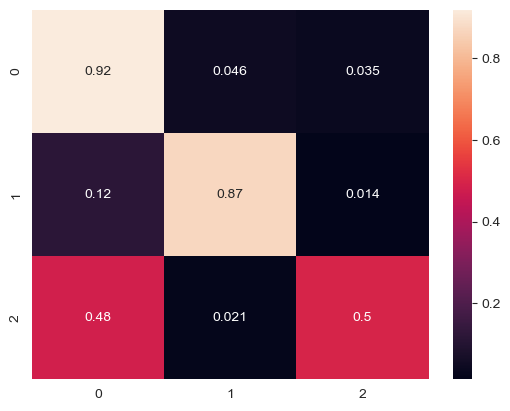

In [55]:
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm, annot=True)

In [56]:
# Support Vector Machine
from sklearn.svm import SVC

svc = SVC(kernel='rbf', class_weight={0:0.9, 1:1.1, 2:2.0}).fit(X_train, y_train)

# Predict on test set
y_pred = svc.predict(X_test)

# Evaluate the model
accuracy_score(y_test, y_pred)

0.8104817363684489

In [57]:
#Let's print accuracy, precision, recall and f1-score
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

      Normal       0.81      0.90      0.85      1134
   Pneumonia       0.87      0.85      0.86       514
Tuberculosis       0.59      0.29      0.39       241

    accuracy                           0.81      1889
   macro avg       0.76      0.68      0.70      1889
weighted avg       0.80      0.81      0.80      1889



<Axes: >

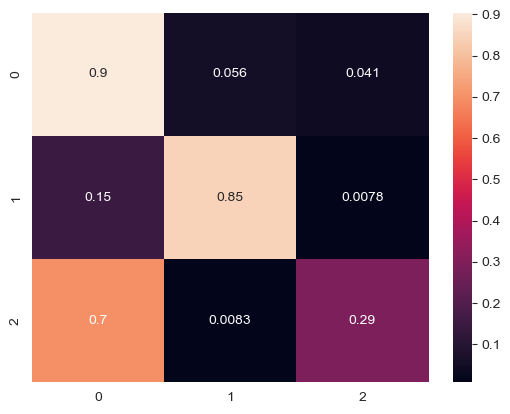

In [58]:
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm, annot=True)

# What have we learnt?
It appears wavelet features might be the best choice, but they are still not very good. While probably handcrafted features are not a good choice to begin with, let's still explore some techniques to improve the results. This is not likely to capture any meaningful pattern in the data, since exploratory data analysis has already been performed yielding no significant results, but it's still a good exercise.

In [59]:
wavelet_feature_names = [i for i in handcrafted_features if 'wavelet' in i]
wavelet_features = handcrafted_features[wavelet_feature_names]
# Entropy features are either NaN or infinite, except for the one corresponding to the matrix cA, so let's drop them
wavelet_features = wavelet_features.drop(columns=[i for i in wavelet_features if 'entropy' in i and 'cA_entropy' not in i])

wavelet_features.describe()

wavelet_cA_energy  wavelet_cA_entropy  wavelet_cA_mean  \
count       1.079200e+04        10792.000000     10792.000000   
mean        2.306048e+10            0.301026       254.187386   
std         4.589435e+10            0.105617        12.969688   
min         1.804164e+09            0.083611       173.700725   
25%         3.092321e+09            0.229750       246.026038   
50%         3.281386e+09            0.268810       257.105827   
75%         2.730955e+10            0.344148       262.363266   
max         5.999483e+11            1.699508       366.256987   

       wavelet_cA_variance  wavelet_cA_skewness  wavelet_cA_kurtosis  \
count         10792.000000         10792.000000         10792.000000   
mean          14401.903311             0.096413            -0.775470   
std            1623.615593             0.120997             0.172169   
min            3239.031237            -0.515765            -1.487428   
25%           13343.095055             0.012191            -0.904868   
50%           14479.907913             0.083970            -0.801681   
75%           15450.408956             0.175833            -0.664466   
max           24738.682847             1.007610             0.609154   

       wavelet_cH_energy  wavelet_cH_mean  wavelet_cH_variance  \
count       1.079200e+04     10792.000000         10792.000000   
mean        4.175901e+06        -0.076352            37.572948   
std         7.825225e+06         0.145719            22.779694   
min         4.663935e+05        -0.557837             0.451638   
25%         1.823998e+06        -0.161000            17.036933   
50%         2.298743e+06        -0.052358            39.340162   
75%         4.261008e+06        -0.001934            52.610490   
max         4.462693e+08         0.594087           435.442450   

       wavelet_cH_skewness  ...  wavelet_cV_energy  wavelet_cV_mean  \
count         10792.000000  ...       1.079200e+04     10792.000000   
mean              0.384023  ...       4.859110e+06        -0.000556   
std               1.279924  ...       7.920382e+06         0.114997   
min              -5.617693  ...       6.376668e+05        -0.550775   
25%              -0.008366  ...       2.127229e+06        -0.032064   
50%               0.151279  ...       2.677708e+06        -0.000386   
75%               0.337912  ...       5.857930e+06         0.027453   
max              15.106138  ...       4.475466e+08         0.567488   

       wavelet_cV_variance  wavelet_cV_skewness  wavelet_cV_kurtosis  \
count         10792.000000         10792.000000         10792.000000   
mean             44.228998             0.030944             9.040538   
std              25.092529             0.405309             9.988028   
min               0.400975            -4.470905            -0.159703   
25%              22.865179            -0.102386             4.848480   
50%              47.663528             0.028066             6.416410   
75%              59.362032             0.156089            10.211909   
max             436.943247             5.394581           240.143987   

       wavelet_cD_energy  wavelet_cD_mean  wavelet_cD_variance  \
count       1.079200e+04     10792.000000         10792.000000   
mean        9.740720e+04        -0.000038             0.921542   
std         1.363456e+05         0.001161             0.757258   
min         7.728500e+03        -0.005487             0.037053   
25%         4.380650e+04        -0.000600             0.376942   
50%         5.731438e+04        -0.000015             0.824164   
75%         1.199354e+05         0.000525             1.350072   
max         7.075612e+06         0.005150            29.440656   

       wavelet_cD_skewness  wavelet_cD_kurtosis  
count         10792.000000         10792.000000  
mean              0.001056             6.877258  
std               0.076372             4.696594  
min              -0.565911             0.029896  
25%              -0.030638             4.41

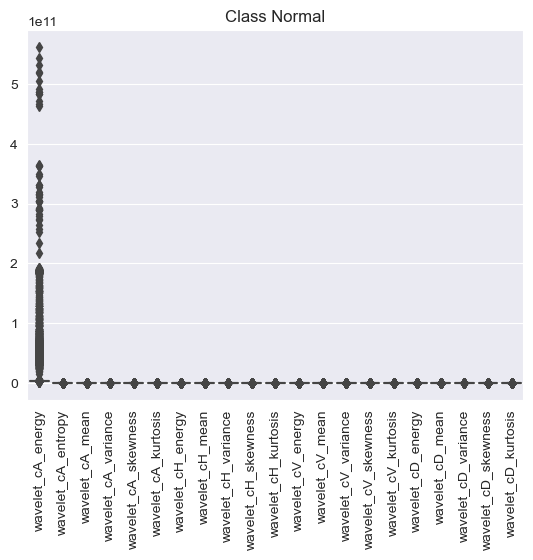

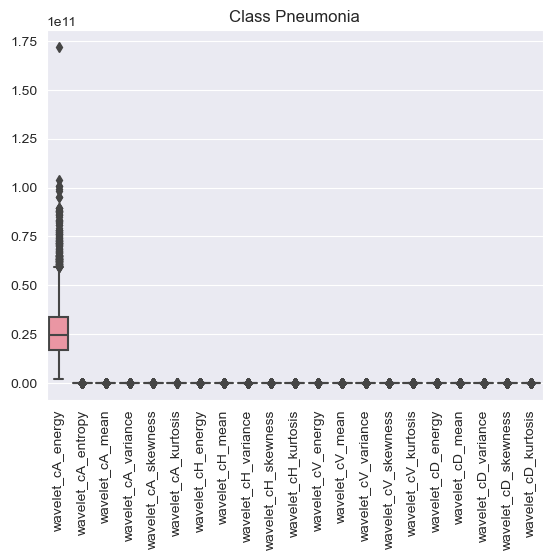

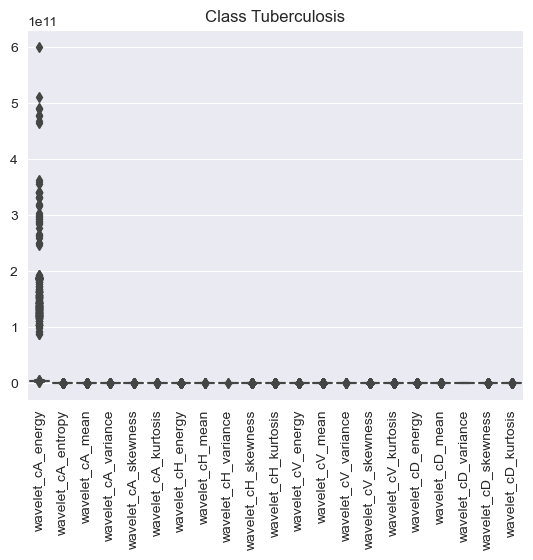

In [60]:
# For each class, let's see the distribution of the features through a boxplot
for i in range(0, 3):
    bp = sns.boxplot(data=wavelet_features[labels_numerical == i])
    bp.set_title('Class {}'.format(class_names[i]))
    bp.set_xticklabels(bp.get_xticklabels(), rotation=90)
    plt.show()

In [61]:
# Scaling is very different among features, for example the cA energy goes up to 1e11, while the others remain in an order of magnitude of 1 or 2, let's apply robust scaling
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
wavelet_features = scaler.fit_transform(wavelet_features)

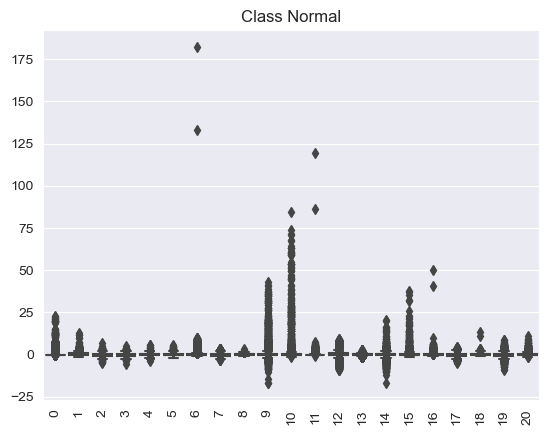

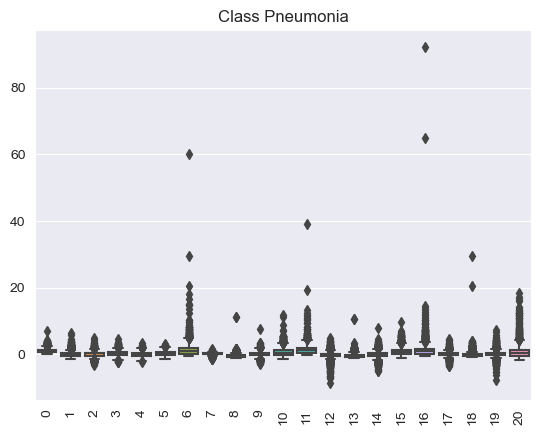

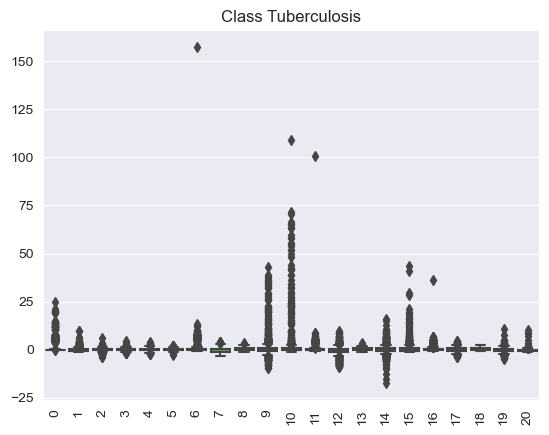

In [62]:
# For each class, let's see the distribution of the features through a boxplot
for i in range(0, 3):
    bp = sns.boxplot(data=wavelet_features[labels_numerical == i])
    bp.set_title('Class {}'.format(class_names[i]))
    bp.set_xticklabels(bp.get_xticklabels(), rotation=90)
    plt.show()

In [63]:
# It still appears like outliers have very high variation, let's try applying windsorization
from scipy.stats.mstats import winsorize
wavelet_features = winsorize(wavelet_features, limits=[0.1, 0.1], axis=0)


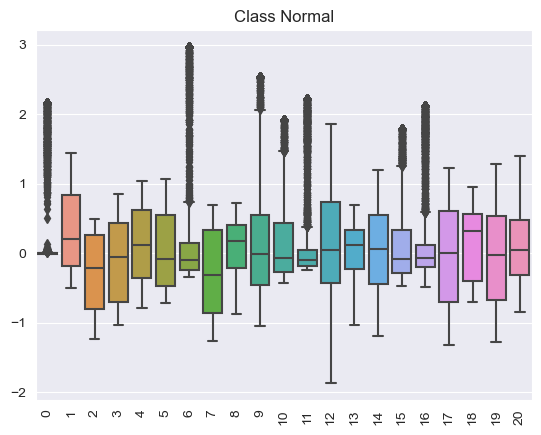

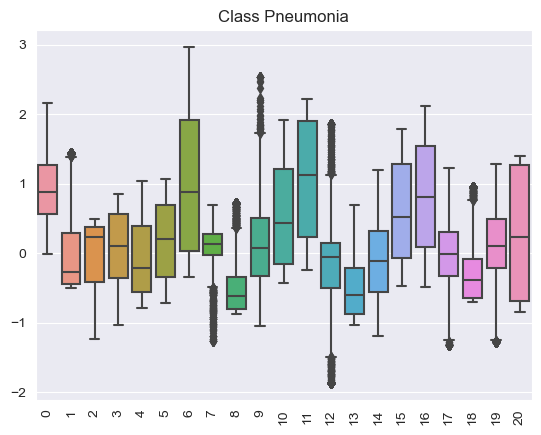

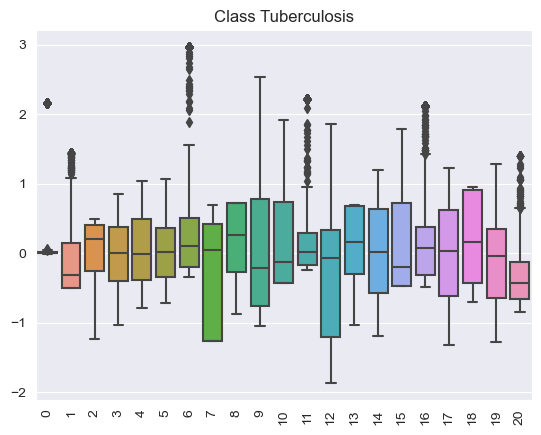

In [64]:
# For each class, let's see the distribution of the features through a boxplot
for i in range(0, 3):
    bp = sns.boxplot(data=wavelet_features[labels_numerical == i])
    bp.set_title('Class {}'.format(class_names[i]))
    bp.set_xticklabels(bp.get_xticklabels(), rotation=90)
    plt.show()

In [65]:
# This is looking much better, let's now try a SVM classifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(wavelet_features, labels_numerical, test_size=0.2)

In [66]:
class_weights = {0: 0.8, 1: 1.0, 2: 3.5}
classifier = SVC(kernel='rbf', gamma='auto', class_weight=class_weights)
classifier.fit(X_train, y_train)

SVC(class_weight={0: 0.8, 1: 1.0, 2: 3.5}, gamma='auto')

In [67]:
# Predict on test set
y_pred = classifier.predict(X_test)

# Evaluate the model
accuracy_score(y_test, y_pred)

0.8485409911996294

In [68]:
#Let's print accuracy, precision, recall and f1-score
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

      Normal       0.92      0.84      0.88      1315
   Pneumonia       0.92      0.87      0.90       591
Tuberculosis       0.53      0.83      0.64       253

    accuracy                           0.85      2159
   macro avg       0.79      0.85      0.81      2159
weighted avg       0.87      0.85      0.86      2159



<Axes: >

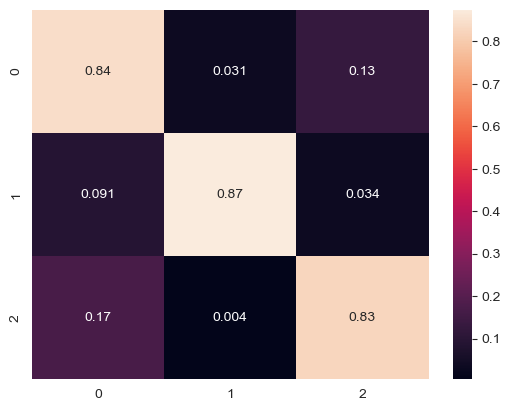

In [69]:
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm, annot=True)

In [70]:
#Let's compute the overall precision, recall and f1-score
from sklearn.metrics import precision_recall_fscore_support
(prec, rec, f1, _) = precision_recall_fscore_support(y_test, y_pred, average='macro')

print(f'Precision: {prec}\nRecall: {rec}\nF1-score: {f1}')

Precision: 0.7902274802048389
Recall: 0.8473133631276144
F1-score: 0.8068941126675009


Let's now try to understand what the model is doing.

In [71]:
wavelet_feature_names_red = ['wavelet_cA_energy', 'wavelet_cA_entropy', 'wavelet_cA_mean', 'wavelet_cA_variance', 'wavelet_cA_skewness', 'wavelet_cA_kurtosis','wavelet_cH_energy', 'wavelet_cH_mean', 'wavelet_cH_variance', 'wavelet_cH_skewness', 'wavelet_cH_kurtosis','wavelet_cV_energy', 'wavelet_cV_mean', 'wavelet_cV_variance', 'wavelet_cV_skewness', 'wavelet_cV_kurtosis','wavelet_cD_energy', 'wavelet_cD_mean', 'wavelet_cD_variance', 'wavelet_cD_skewness', 'wavelet_cD_kurtosis']

In [72]:
# Permuation importance
import eli5
from eli5.sklearn import PermutationImportance
perm = PermutationImportance(classifier).fit(X_test, y_test)

In [73]:
eli5.show_weights(perm, feature_names=wavelet_feature_names_red)

Partial dependence plots were not produced because of the lack of compatibility of the library on the system used.

We tried also shapeley values, but the time required to compute them was too high.

# Glassbox Models

In [74]:
labels_numerical = np.argmax(handcrafted_labels, axis=1)

In [75]:
wavelet_feature_names = [i for i in handcrafted_features if 'wavelet' in i]
wavelet_features = handcrafted_features[wavelet_feature_names]
# Entropy features are either NaN or infinite, except for the one corresponding to the matrix cA, so let's drop them
wavelet_features = wavelet_features.drop(columns=[i for i in wavelet_features if 'entropy' in i and 'cA_entropy' not in i])

from scipy.stats.mstats import winsorize
wavelet_features = wavelet_features.to_numpy()
wavelet_features = winsorize(wavelet_features, limits=[0.1, 0.1], axis=0)

In [76]:
from sklearn.model_selection import train_test_split
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(wavelet_features, labels_numerical, test_size=0.2)

In [77]:
# Let's try a natively explainable model, Explainable Boosting Machine
from interpret.glassbox import ExplainableBoostingClassifier

remained_feature_names = wavelet_feature_names.copy()

for i in wavelet_feature_names:
    if 'entropy' in i and 'cA_entropy' not in i:
        remained_feature_names.remove(i)

class_weights = {0: 0.8, 1: 1.0, 2: 3.5}
sample_weights = np.array([class_weights[i] for i in y_train])

ebm = ExplainableBoostingClassifier(feature_names=remained_feature_names)
ebm.fit(X_train, y_train,sample_weight=sample_weights)

ExplainableBoostingClassifier(feature_names=['wavelet_cA_energy',
                                             'wavelet_cA_entropy',
                                             'wavelet_cA_mean',
                                             'wavelet_cA_variance',
                                             'wavelet_cA_skewness',
                                             'wavelet_cA_kurtosis',
                                             'wavelet_cH_energy',
                                             'wavelet_cH_mean',
                                             'wavelet_cH_variance',
                                             'wavelet_cH_skewness',
                                             'wavelet_cH_kurtosis',
                                             'wavelet_cV_energy',
                                             'wavelet_cV_mean',
                                             'wavelet_cV_variance',
                                             'wavelet_cV_skewness',
                                             'wavelet_cV_kurtosis',
                                             'wavelet_cD_energy',
                                             'wavelet_cD_mean',
                                             'wavelet_cD_variance',
                                             'wavelet_cD_skewness',
                                             'wavelet_cD_kurtosis'])

In [78]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Predict on test set
y_pred = ebm.predict(X_test)

# Evaluate the model
accuracy_score(y_test, y_pred)

0.8300138953219083

In [79]:
#Let's print accuracy, precision, recall and f1-score
#Let's compute the overall precision, recall and f1-score
from sklearn.metrics import precision_recall_fscore_support
(prec, rec, f1, _) = precision_recall_fscore_support(y_test, y_pred, average='macro')

print(f'Precision: {prec}\nRecall: {rec}\nF1-score: {f1}')

print(classification_report(y_test, y_pred, target_names=class_names))

Precision: 0.7622926934256266
Recall: 0.8203898509706132
F1-score: 0.7807856923530038
              precision    recall  f1-score   support

      Normal       0.91      0.82      0.87      1332
   Pneumonia       0.88      0.87      0.88       580
Tuberculosis       0.49      0.77      0.60       247

    accuracy                           0.83      2159
   macro avg       0.76      0.82      0.78      2159
weighted avg       0.86      0.83      0.84      2159



<Axes: >

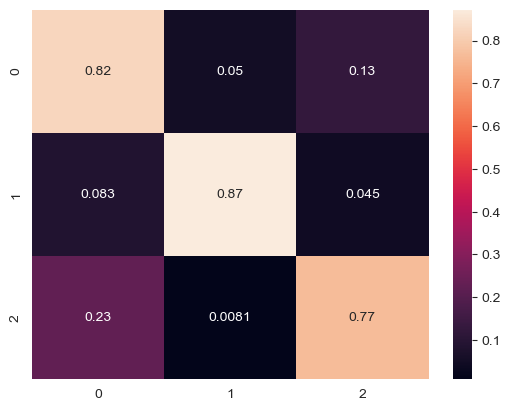

In [80]:
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm, annot=True)

AUC: 0.943


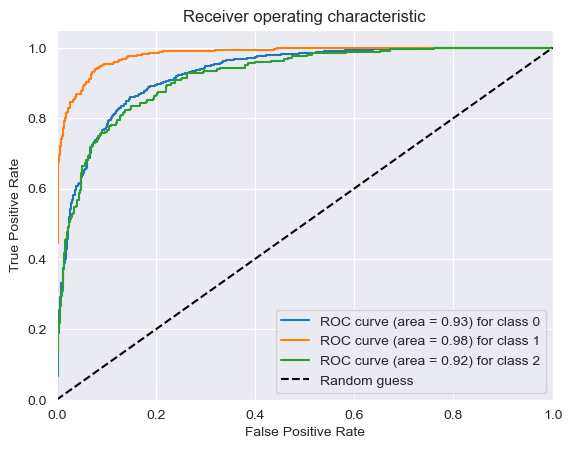

In [81]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test, ebm.predict_proba(X_test)[:], multi_class='ovr')
print("AUC: {:.3f}".format(auc))

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Predict the probabilities for each class on the test data
y_scores = ebm.predict_proba(X_test)

# Binarize the labels
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
for i in range(3):
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for class %d' % (roc_auc[i], i))
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [103]:
# Let's interpret the first prediction
ebm_local = ebm.explain_local(X_test, y_test)

from interpret import show
show(ebm_local)

<!-- http://127.0.0.1:7001/1855362894960/ -->